### FID Computation

In [ ]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import random
from collections import defaultdict
from himyb.datasets.biased_mnist import get_dataloader

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# FID metric on the right device
fid = FrechetInceptionDistance(feature=2048).to(device)

# Inception Score (use feature=2048 for standard InceptionV3, splits=10 recommended)
is_metric = InceptionScore(splits=10).to(device)

# KID
kid = KernelInceptionDistance().to(device)

# Custom Dataset with class-based random sampling
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None, per_class_limit=None):
        # Group image paths by class (detected from filename)
        class_to_paths = defaultdict(list)
        for fname in os.listdir(folder_path):
            if fname.lower().endswith('.png'):
                # Extract class from filename (e.g., ..._class0.png)
                if "_class" in fname:
                    class_part = fname.split("_class")[-1]
                    class_id = ''.join([c for c in class_part if c.isdigit()])
                    if class_id != "":
                        class_to_paths[class_id].append(os.path.join(folder_path, fname))
                else:
                    # If no class in filename, treat as class 'unknown'
                    class_to_paths["unknown"].append(os.path.join(folder_path, fname))

        # If per_class_limit is set, randomly sample up to that many per class
        self.image_paths = []
        if per_class_limit is not None:
            for paths in class_to_paths.values():
                if len(paths) > per_class_limit:
                    self.image_paths.extend(random.sample(paths, per_class_limit))
                else:
                    self.image_paths.extend(paths)
        else:
            for paths in class_to_paths.values():
                self.image_paths.extend(paths)

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        img = (img * 255).type(torch.uint8)  # Convert to [0, 255] uint8
        return img

# Paths to generated images 
def get_gen_image_paths(weights):
    base_path = "/mnt/fast_disk/agjergji/Datasets/generated_images_ddpm_bmnist/"
    return [f"{base_path}/w{w}" for w in weights]

# Choose which weights to include
# selected_weights = ["w_0.1", "w_0.3", "w_0.5", "w_0.8", "w_1.0", "w_2.0", "w_5.0", "w_10.0"]
selected_timesteps = ["T_500", "T_600", "T_700", "T_800", "T_900", "T_1000"]

gen_images_paths = get_gen_image_paths(selected_timesteps)

# Path to real images
real_images_path = "/home/anigjergji/DiffusingDeBias/DiffusingBias/data/bffhq/test"

dataset_name = "bmnist"  # or "bffhq", "waterbirds", etc.

for path in gen_images_paths:
    if not os.path.exists(path):
        print(f"Path {path} does not exist. Skipping...")
        continue
    else:
        print(f"Processing generated images from {path}")
    gen_images_path = path

    if dataset_name != "bmnist":

        # Transform to resize and convert images
        resize_transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize as you intended
            transforms.ToTensor()
        ])
        # Datasets
        real_dataset = ImageFolderDataset(real_images_path, transform=resize_transform)
        gen_dataset = ImageFolderDataset(gen_images_path, transform=resize_transform, per_class_limit=None)  # Limit to 1000 images per class
        print(f"Real dataset size: {len(real_dataset)}")
        print(f"Generated dataset size: {len(gen_dataset)}")

        # DataLoaders with controlled workers
        batch_size = 64
        num_workers = 2

        real_loader = DataLoader(real_dataset, batch_size=batch_size, num_workers=num_workers)
        gen_loader = DataLoader(gen_dataset, batch_size=batch_size, num_workers=num_workers)

    else:

        # Transform to resize and convert images
        resize_transform = transforms.Compose([
            transforms.Resize((32, 32)),  # Resize as you intended
            transforms.ToTensor()
        ])
        # For Biased MNIST, use the provided get_dataloader function
        real_loader = get_dataloader(root='./data', batch_size=64, rho=0.9,
                                     n_confusing_labels=1, train=False, num_workers=2, classes_to_use=[0, 1],
                                     pin_memory=True, resolution=(32, 32))
        
        gen_dataset = ImageFolderDataset(gen_images_path, transform=resize_transform, per_class_limit=None)  # Limit to 1000 images per class
        # DataLoaders with controlled workers
        batch_size = 64
        num_workers = 2

        gen_loader = DataLoader(gen_dataset, batch_size=batch_size, num_workers=num_workers)


    # Example loop for generated images
    for batch in gen_loader:
        batch = batch.to(device)
        fid.update(batch, real=False)
        is_metric.update(batch)
        kid.update(batch, real=False)

    # Real images for FID and KID
    for batch in real_loader:
        batch = batch.to(device)
        fid.update(batch, real=True)
        kid.update(batch, real=True)

    # Compute metrics
    fid_score = fid.compute()
    is_mean, is_std = is_metric.compute()
    kid_mean, kid_std = kid.compute()

    print(f"FID: {fid_score.item():.2f}")
    print(f"Inception Score: {is_mean.item():.2f} ± {is_std.item():.2f}")
    print(f"KID: {kid_mean.item():.4f} ± {kid_std.item():.4f}")


### DDPM evaluation


In [1]:
"""
Nathan Roos

Defines a class LlavaOracle that uses the LLaVA model to predict
the gender of people in images.
It could easily be adapted to predict other attributes.
"""

import torch
import transformers
import PIL

# Load the model and processor:
# We do it at the beginning of the file and not in the class
# so that even though several instances of the class are created, the model
# is loaded only once

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print("LlavaOracle: Loading model and processor...")
model = transformers.LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16, device_map=device
)
processor = transformers.AutoProcessor.from_pretrained(
    "llava-hf/llava-1.5-7b-hf", use_fast=False
)


class LlavaOracle:
    """
    LlavaOracle class that uses the LLaVA multimodal model to predict attributes
    in images, such as gender.
    """

    def __init__(self):
        self.model = model
        self.processor = processor
        # Gender conversation and prompt
        self.gender_conversation = [
            {
            "role": "user",
            "content": [
                {"type": "image"},
                {
                "type": "text",
                "text": "Is the person a male ? (answer only with yes or no)",
                },
            ],
            },
        ]
        self.gender_prompt = self.processor.apply_chat_template(
            self.gender_conversation, add_generation_prompt=True, tokenize=False
        )

        # Age conversation and prompt
        self.age_conversation = [
            {
            "role": "user",
            "content": [
                {"type": "image"},
                {
                "type": "text",
                "text": "Is the person young ? (answer only with yes or no)",
                },
            ],
            },
        ]
        self.age_prompt = self.processor.apply_chat_template(
            self.age_conversation, add_generation_prompt=True, tokenize=False
        )

    def predict_gender(self, images):
        """
        Predicts the genders of the people in the images
        We prompt the model once for each image. If the model
        fails to answer by yes or no, we return None for that image.

        Args:
            images (list): A list of PIL images
        Returns:
            _ : a list of int or None the same size as images: \
                  1 for male, 0 for female, None if the prediction failed
        """
        return self._ask_model(images, self.gender_prompt)

    def predict_age(self, images):
        """
        Predicts the ages of the people in the images
        We prompt the model once for each image. If the model
        fails to answer by yes or no, we return None for that image.

        Args:
            images (list): A list of PIL images
        Returns:
            _ : a list of int or None the same size as images: \
                  1 for young, 0 for old, None if the prediction failed
        """
        return self._ask_model(images, self.age_prompt)

    def _ask_model(
        self, images, prompt
    ):
        """
        Asks the model to predict the answer to the prompt
        If the model answers with "yes" or "no", we return 1 or 0 respectively
        If the model answers with something else, we return None

        Args:
            images (list): A list of PIL images
            prompt (str): The prompt to ask the model
        Returns:
            labels: a list of int or None the same length as images: 1 for yes, 0 for no, \
            None if the answer is something else (ie the model failed to answer)
        """
        n_imgs = len(images)
        prompts = [prompt] * n_imgs
        inputs = processor(
            text=prompts, images=images, padding=True, return_tensors="pt"
        ).to(model.device, torch.float16)
        generate_ids = model.generate(**inputs, max_new_tokens=1)
        outputs = processor.batch_decode(generate_ids, skip_special_tokens=True)
        answers = self.__extract_answer(outputs)
        labels = self.__is_answer_yes(answers)
        return labels

    def __extract_answer(self, outputs):
        """
        Extracts the answer of the model from the model output.

        Args:
            outputs (list[str] | str):  asingle output or a list of outputs from the model
        Returns:
            a single string or a list of strings: the answer of the model
        """
        if isinstance(outputs, list):
            return [self.__extract_answer(r) for r in outputs]
        return outputs.split("ASSISTANT:")[-1].strip()

    def __is_answer_yes(
        self, answers
    ):
        """
        Checks if the answer is "yes" or "no"
        If the answer is "yes", we return 1
        If the answer is "no", we return 0
        If the answer is something else, we return None

        Args:
            answers (list[str] | str): a single answer of the model or a list of answers
        Returns:
            out: a list of int or None the same size as answers: \
            1 for yes, 0 for no, None if the answer is something else
        """
        if isinstance(answers, list):
            return [self.__is_answer_yes(r) for r in answers]

        answers = answers.strip().lower()
        out = None
        if answers == "yes":
            out = 1
        elif answers == "no":
            out = 0
        return out


/home/ani/ani/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LlavaOracle: Loading model and processor...


Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


In [ ]:
import os
from PIL import Image
from tqdm import tqdm

# Path to generated images from DDPM
# Change this to the path where your generated images are stored
gen_images_path = "/mnt/fast_disk/agjergji/Datasets/bffhq_ddpm_gen/individual_samples"

# Collect eligible images (fully visible faces)
eligible_images = []
eligible_image_paths = []

for filename in tqdm(os.listdir(gen_images_path)):
    if filename.lower().endswith((".png")):
        img_path = os.path.join(gen_images_path, filename)
        if is_face_fully_visible_dnn(img_path, confidence_threshold=0.95, margin=0, check_single_face=False):
            img = Image.open(img_path).convert("RGB")
            eligible_images.append(img)
            eligible_image_paths.append(img_path)

print(f"Found {len(eligible_images)} images with fully visible faces.")

100%|██████████| 10000/10000 [02:13<00:00, 75.09it/s]

Found 9682 images with fully visible faces.


In [ ]:

oracle = LlavaOracle()

batch_size = 6
old_count, young_count, unknown_count = 0, 0, 0

old_paths = []
young_paths = []
unknown_paths = []

for i in tqdm(range(0, len(eligible_images), batch_size)):
    batch_images = eligible_images[i : i + batch_size]
    batch_paths = eligible_image_paths[i : i + batch_size]

    predictions = oracle.predict_age(batch_images)

    for pred, path in zip(predictions, batch_paths):
        if pred == 1:
            old_count += 1
            old_paths.append(path)
        elif pred == 0:
            young_count += 1
            young_paths.append(path)
        else:
            unknown_count += 1
            unknown_paths.append(path)

total = old_count + young_count
print(f"\nAge Distribution among generated images with visible faces:")
print(f"  Old:   {old_count} ({old_count/total*100:.2f}%)")
print(f"  Young: {young_count} ({young_count/total*100:.2f}%)")
print(f"  Unknown/Uncertain: {unknown_count}")

save_paths = {
    "old": old_paths,
    "young": young_paths,
    "unknown": unknown_paths
}

import json
with open("age_paths.json", "w") as f:
    json.dump(save_paths, f)


100%|██████████| 1614/1614 [28:20<00:00,  1.05s/it]


Age Distribution among generated images with visible faces:
  Old:   3869 (39.96%)
  Young: 5813 (60.04%)
  Unknown/Uncertain: 0


In [ ]:
import json
from tqdm import tqdm
from PIL import Image

# Load the paths from the file
with open("age_paths.json", "r") as f:
    save_paths = json.load(f)

old_paths = save_paths.get("old", [])
young_paths = save_paths.get("young", [])
unknown_paths = save_paths.get("unknown", [])

batch_size = 6

# First, get age distribution for males
male_count, female_count, unknown = 0, 0, 0
for i in tqdm(range(0, len(old_paths), batch_size)):
    batch_paths = old_paths[i : i + batch_size]
    batch_images = [Image.open(p).convert("RGB") for p in batch_paths]

    predictions = oracle.predict_gender(batch_images) 

    for pred in predictions:
        if pred == 1:
            male_count += 1
        elif pred == 0:
            female_count += 1
        else:
            unknown += 1


total = male_count + female_count
print(f"\nAge Distribution among generated OLD images with visible faces:")
print(f"  Males:   {male_count} ({male_count/total*100:.2f}%)")
print(f"  Females: {female_count} ({female_count/total*100:.2f}%)")
print(f"  Unknown/Uncertain: {unknown}")

# Then, get age distribution for females
male_count, female_count, unknown = 0, 0, 0
for i in tqdm(range(0, len(young_paths), batch_size)):
    batch_paths = young_paths[i : i + batch_size]
    batch_images = [Image.open(p).convert("RGB") for p in batch_paths]

    predictions = oracle.predict_gender(batch_images) 

    for pred in predictions:
        if pred == 1:
            male_count += 1
        elif pred == 0:
            female_count += 1
        else:
            unknown += 1

total = male_count + female_count
print(f"\nAge Distribution among generated YOUNG images with visible faces:")
print(f"  Males:   {male_count} ({male_count/total*100:.2f}%)")
print(f"  Females: {female_count} ({female_count/total*100:.2f}%)")
print(f"  Unknown/Uncertain: {unknown}")


100%|██████████| 645/645 [11:15<00:00,  1.05s/it]



Age Distribution among generated MALE images with visible faces:
  Males:   3748 (96.87%)
  Females: 121 (3.13%)
  Unknown/Uncertain: 0


100%|██████████| 969/969 [17:04<00:00,  1.06s/it]


Age Distribution among generated FEMALE images with visible faces:
  Males:   826 (14.21%)
  Females: 4987 (85.79%)
  Unknown/Uncertain: 0


### Rho computation CDDPM


In [ ]:
import os
import numpy as np
import torch
import tqdm
import glob
from PIL import Image
import random
import re

class FFHQOracle:
    def __init__(self):
        # Create the actual oracle instance
        self.oracle = LlavaOracle()
    
    def is_male_oracle(self, image_pil):
        """
        Takes a PIL Image and returns True if male, False if female.
        """
        try:
            # predict_gender expects a list of PIL Images
            gender_predictions = self.oracle.predict_gender([image_pil])
            # Returns list of [1 for male, 0 for female, None if failed]
            prediction = gender_predictions[0]
            if prediction is None:
                # If prediction failed, default to False (female)
                return False
            return prediction == 1  # True if male (1), False if female (0)
        except Exception as e:
            print(f"Oracle prediction failed: {e}")
            return False

# Instantiate the oracle
ffhq_oracle = FFHQOracle()


def dump_dict_to_file(dump_dict, file_name):
    with open(file_name, "w", encoding="utf-8") as f:
        for key, value in dump_dict.items():
            f.write(f"{key}: {value}\n")


def get_class_label_from_filename(filename):
    """
    Extracts the class label (0 for young, 1 for old) from the filename.
    Assumes the filename format includes "_classX" where X is 0 or 1.
    e.g., "sample_0001_class0..." -> class 0
    e.g.,
          "sample_0002_class1..." -> class 1
    """
    match = re.search(r'_class(\d+)', filename)
    if match:
        return int(match.group(1))
    return None # Or raise an error if expected to always find it


# --- Configuration for FFHQ ---
# Update ROOT_DIR to where your FFHQ generated samples are stored
ROOT_DIR = "/data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/"  # <--- IMPORTANT: Update this path
RUN_NAMES = []
for T in [500, 600, 700, 800, 900]:
    for w in [0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0]:
        RUN_NAMES.append(f"T_{T}/w_{w}/")

# We have two explicit conditioning classes: 0 (young) and 1 (old)
NUM_CLASSES = 2

# We have two bias categories: 0 (female) and 1 (male)
NUM_BIAS_CATEGORIES = 2  # 0 for Female, 1 for Male

# Batch size for processing existing images
BATCH_SIZE = 8

IMGS_PER_CLASS = 1000  # Number of images to sample per class

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

for run_name in RUN_NAMES:
    run_dir = os.path.join(ROOT_DIR, run_name)
    # generated_samples_dir = os.path.join(run_dir, "individual_samples")  # <--- IMPORTANT: Subfolder where images are
    generated_samples_dir = run_dir
    if not os.path.isdir(generated_samples_dir):
        print(f"Error: Directory '{generated_samples_dir}' not found. Skipping run '{run_name}'.")
        continue

    # List all image files in the generated_samples_dir
    image_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_files.extend(glob.glob(os.path.join(generated_samples_dir, ext)))
    image_files = sorted(image_files)

    if not image_files:
        print(f"No images found in '{generated_samples_dir}'. Skipping run '{run_name}'.")
        continue

    # Filter out files that don't have a class label in their name, if any
    # Store tuples of (filepath, class_label)
    processed_image_info = []
    for img_path in image_files:
        filename = os.path.basename(img_path)
        class_label = get_class_label_from_filename(filename)
        if class_label is not None and 0 <= class_label < NUM_CLASSES:
            processed_image_info.append((img_path, class_label))
        else:
            print(f"Warning: Could not extract valid class label from filename: {filename}. Skipping.")

    total_images_to_process = len(processed_image_info)
    if total_images_to_process == 0:
        print(f"No valid images with class labels found in '{generated_samples_dir}'. Skipping run '{run_name}'.")
        continue

    print(f"Processing {total_images_to_process} images for run: {run_name}")

    ## load or create matrix of class-bias counts
    save_file_name = "analyzed_bias_matrix_bffhq"
    matrix_file = os.path.join(run_dir, f"{save_file_name}.csv")

    # The matrix will have dimensions: (NUM_CLASSES, NUM_BIAS_CATEGORIES)
    # Rows: Class 0 (young), Class 1 (old)
    # Columns: Bias 0 (female), Bias 1 (male)
    matrix = np.zeros((NUM_CLASSES, NUM_BIAS_CATEGORIES)).astype(int)

    # If an existing matrix file exists, load it and ensure its shape matches
    if os.path.exists(matrix_file):
        print(f"Matrix file exists for run {run_name}. Loading and continuing analysis.")
        loaded_matrix = np.loadtxt(matrix_file, delimiter=",")
        if loaded_matrix.shape == matrix.shape:
            matrix = loaded_matrix.astype(int)
        else:
            print(f"Warning: Existing matrix shape {loaded_matrix.shape} does not match expected {matrix.shape}. "
                  "Starting with a new empty matrix.")
    else:
        print(f"No existing matrix file found for run {run_name}. Creating a new one.")

    # take 1000 images per class randomly selected
    if total_images_to_process > IMGS_PER_CLASS:
        print(f"Warning: More than {IMGS_PER_CLASS} images found for run {run_name}. Randomly selecting {IMGS_PER_CLASS} images per class.")
        class_0_images = [info for info in processed_image_info if info[1] == 0]
        class_1_images = [info for info in processed_image_info if info[1] == 1]

        selected_class_0 = random.sample(class_0_images, k=IMGS_PER_CLASS)
        selected_class_1 = random.sample(class_1_images, k=IMGS_PER_CLASS)

        processed_image_info = list(selected_class_0) + list(selected_class_1)
        total_images_to_process = len(processed_image_info)
        print(f"Selected {len(selected_class_0)} images from class 0 and {len(selected_class_1)} images from class 1. Total: {total_images_to_process}")

    # Process images in batches
    for i in tqdm.tqdm(range(0, total_images_to_process, BATCH_SIZE), desc=f"Analyzing {run_name} images"):
        batch_info = processed_image_info[i:i + BATCH_SIZE]
        images_batch_pil = []
        batch_class_labels = []

        for img_path, class_label in batch_info:
            try:
                img = Image.open(img_path).convert('RGB')
                images_batch_pil.append(img)
                batch_class_labels.append(class_label)
            except Exception as e:
                print(f"Error loading or processing image {img_path}: {e}. Skipping.")
                continue

        if not images_batch_pil:
            continue

        # Get bias labels (gender) using the oracle - process batch at once
        try:
            # Use the oracle's batch prediction capability
            bias_predictions = ffhq_oracle.oracle.predict_gender(images_batch_pil)
            bias_labels = []
            for prediction in bias_predictions:
                if prediction is None:
                    print("Warning: Oracle prediction failed for an image. Assuming False (female).")
                    bias_labels.append(0)  # Default to female
                else:
                    bias_labels.append(prediction)  # 1 for male, 0 for female
        except Exception as e:
            print(f"Error running oracle on batch: {e}. Assuming all female.")
            bias_labels = [0] * len(images_batch_pil)  # Default all to female

        # Add counts to matrix
        for j, class_label in enumerate(batch_class_labels):
            bias_label = bias_labels[j]
            if 0 <= class_label < NUM_CLASSES and 0 <= bias_label < NUM_BIAS_CATEGORIES:
                matrix[class_label, bias_label] += 1
            else:
                print(f"Warning: Invalid class_label ({class_label}) or bias_label ({bias_label}) encountered. Skipping count.")

    # Save matrix
    np.savetxt(matrix_file, matrix, delimiter=",")
    print(f"Bias matrix saved to: {matrix_file}")

    # Dump configuration
    dump_dict_to_file(
        {
            "run_name": run_name,
            "path": str(run_dir),
            "batch_size_for_analysis": BATCH_SIZE,
            "total_images_analyzed": total_images_to_process,
            "num_conditioning_classes": NUM_CLASSES, # Number of age classes (young/old)
            "num_bias_categories": NUM_BIAS_CATEGORIES, # Number of gender categories (female/male)
            "bias_category_0": "Female", # For clarity in the config
            "bias_category_1": "Male",   # For clarity in the config
            "class_0_label": "Young",
            "class_1_label": "Old",
        },
        os.path.join(run_dir, f"{save_file_name}_config.txt"),
    )
    print(f"Configuration saved to: {os.path.join(run_dir, f'{save_file_name}_config.txt')}\n")

print("Analysis complete for all runs.")

Using device: cuda:1
Processing 2000 images for run: T_500/w_0.1/
No existing matrix file found for run T_500/w_0.1/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_500/w_0.1/ images:   0%|          | 0/250 [00:00<?, ?it/s]

Analyzing T_500/w_0.1/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_0.1/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_0.1/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_500/w_0.3/
No existing matrix file found for run T_500/w_0.3/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_500/w_0.3/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_0.3/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_0.3/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_500/w_0.5/
No existing matrix file found for run T_500/w_0.5/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_500/w_0.5/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_0.5/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_0.5/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_500/w_0.8/
No existing matrix file found for run T_500/w_0.8/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_500/w_0.8/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_0.8/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_0.8/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_500/w_1.0/
No existing matrix file found for run T_500/w_1.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_500/w_1.0/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_1.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_1.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_500/w_2.0/
No existing matrix file found for run T_500/w_2.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_500/w_2.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_2.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_2.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_500/w_5.0/
No existing matrix file found for run T_500/w_5.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_500/w_5.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_5.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_5.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_500/w_10.0/
No existing matrix file found for run T_500/w_10.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_500/w_10.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_10.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_500/w_10.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_600/w_0.1/
No existing matrix file found for run T_600/w_0.1/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_600/w_0.1/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_0.1/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_0.1/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_600/w_0.3/
No existing matrix file found for run T_600/w_0.3/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_600/w_0.3/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_0.3/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_0.3/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_600/w_0.5/
No existing matrix file found for run T_600/w_0.5/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_600/w_0.5/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_0.5/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_0.5/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_600/w_0.8/
No existing matrix file found for run T_600/w_0.8/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_600/w_0.8/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_0.8/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_0.8/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_600/w_1.0/
No existing matrix file found for run T_600/w_1.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_600/w_1.0/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_1.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_1.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_600/w_2.0/
No existing matrix file found for run T_600/w_2.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_600/w_2.0/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_2.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_2.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_600/w_5.0/
No existing matrix file found for run T_600/w_5.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_600/w_5.0/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_5.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_5.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_600/w_10.0/
No existing matrix file found for run T_600/w_10.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_600/w_10.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_10.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_600/w_10.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_700/w_0.1/
No existing matrix file found for run T_700/w_0.1/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_700/w_0.1/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_0.1/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_0.1/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_700/w_0.3/
No existing matrix file found for run T_700/w_0.3/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_700/w_0.3/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_0.3/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_0.3/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_700/w_0.5/
No existing matrix file found for run T_700/w_0.5/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_700/w_0.5/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_0.5/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_0.5/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_700/w_0.8/
No existing matrix file found for run T_700/w_0.8/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_700/w_0.8/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_0.8/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_0.8/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_700/w_1.0/
No existing matrix file found for run T_700/w_1.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_700/w_1.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_1.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_1.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_700/w_2.0/
No existing matrix file found for run T_700/w_2.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_700/w_2.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_2.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_2.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_700/w_5.0/
No existing matrix file found for run T_700/w_5.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_700/w_5.0/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_5.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_5.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_700/w_10.0/
No existing matrix file found for run T_700/w_10.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_700/w_10.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_10.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_700/w_10.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_800/w_0.1/
No existing matrix file found for run T_800/w_0.1/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_800/w_0.1/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_0.1/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_0.1/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_800/w_0.3/
No existing matrix file found for run T_800/w_0.3/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_800/w_0.3/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_0.3/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_0.3/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_800/w_0.5/
No existing matrix file found for run T_800/w_0.5/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_800/w_0.5/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_0.5/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_0.5/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_800/w_0.8/
No existing matrix file found for run T_800/w_0.8/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_800/w_0.8/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_0.8/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_0.8/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_800/w_1.0/
No existing matrix file found for run T_800/w_1.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_800/w_1.0/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_1.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_1.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_800/w_2.0/
No existing matrix file found for run T_800/w_2.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_800/w_2.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_2.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_2.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_800/w_5.0/
No existing matrix file found for run T_800/w_5.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_800/w_5.0/ images: 100%|██████████| 250/250 [03:56<00:00,  1.06it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_5.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_5.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_800/w_10.0/
No existing matrix file found for run T_800/w_10.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_800/w_10.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_10.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_800/w_10.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_900/w_0.1/
No existing matrix file found for run T_900/w_0.1/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_900/w_0.1/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_0.1/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_0.1/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_900/w_0.3/
No existing matrix file found for run T_900/w_0.3/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_900/w_0.3/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_0.3/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_0.3/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_900/w_0.5/
No existing matrix file found for run T_900/w_0.5/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_900/w_0.5/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_0.5/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_0.5/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_900/w_0.8/
No existing matrix file found for run T_900/w_0.8/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_900/w_0.8/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_0.8/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_0.8/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_900/w_1.0/
No existing matrix file found for run T_900/w_1.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_900/w_1.0/ images: 100%|██████████| 250/250 [03:58<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_1.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_1.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_900/w_2.0/
No existing matrix file found for run T_900/w_2.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_900/w_2.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_2.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_2.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_900/w_5.0/
No existing matrix file found for run T_900/w_5.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_900/w_5.0/ images: 100%|██████████| 250/250 [03:56<00:00,  1.06it/s]


Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_5.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_5.0/analyzed_bias_matrix_bffhq_config.txt

Processing 2000 images for run: T_900/w_10.0/
No existing matrix file found for run T_900/w_10.0/. Creating a new one.
Selected 1000 images from class 0 and 1000 images from class 1. Total: 2000


Analyzing T_900/w_10.0/ images: 100%|██████████| 250/250 [03:57<00:00,  1.05it/s]

Bias matrix saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_10.0/analyzed_bias_matrix_bffhq.csv
Configuration saved to: /data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/T_900/w_10.0/analyzed_bias_matrix_bffhq_config.txt

Analysis complete for all runs.


In [ ]:
import numpy as np 
import scipy

%matplotlib inline

def get_rho_confidence_interval(mat, confidence_level=0.95):
    """
    Compute an estimation of the model rho and its confidence interval.
    

    **WARNING**: The matrix should NOT contain the results for the unconditional class.
    If you just loaded the matrix from a file, it is likely that the matrix
    is of shape (n_classes+1, n_classes + 1), in which case you should
    remove the last row and the last column before calling this function, eg:
    
    ```python
    get_rho_confidence_interval(mat[:n_classes, :n_classes], confidence_level)
    ```

    Args:
        mat (np.array): numpy array of shape (n_classes, n_classes) where mat(i,j) is the number\
            of images with bias j that where generated with the class conditionning i.\
            It should NOT contain the results for the unconditional class.
        confidence_level (float): confidence level for the confidence interval, default is 0.95.
    """
    nb_aligned = int(np.trace(mat))
    nb_total = int(np.sum(mat))
    est_rho_model = nb_aligned / nb_total
    res = scipy.stats.binomtest(k=nb_aligned, n=nb_total)
    conf_int = res.proportion_ci(confidence_level=confidence_level, method='exact')
    return est_rho_model, (conf_int.low, conf_int.high)

In [ ]:
import numpy as np


ROOT_DIR = "/data05/ani/GenImages/conditioned/DpmSolver++50s_3o/bffhq/" 
RUN_NAMES = []
for T in [500, 600, 700, 800, 900]:
    for w in [0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0]:
        RUN_NAMES.append(f"T_{T}/w_{w}/")

results = { "T_500": [], "T_600": [], "T_700": [], "T_800": [], "T_900": [] }

# Loop through each unique run name to process the corresponding file
for run_name in RUN_NAMES:
    matrix_file_path = f"{ROOT_DIR}/{run_name}/analyzed_bias_matrix_bffhq.csv"
    
    # Extract T and w from the run_name
    parts = run_name.split('/')
    run_key = parts[0]
    guidance_val = parts[1]
    
    # Process the data
    try:
        matrix = np.loadtxt(matrix_file_path, delimiter=',')
        estimated_rho, confidence_interval = get_rho_confidence_interval(matrix)
        
        # Append to the results dictionary using the extracted keys
        results[run_key].append({
            "guidance": guidance_val,
            "rho": estimated_rho,
            "conf_low": confidence_interval[0],
            "conf_high": confidence_interval[1]
        })
        
        print(f"Run: {run_name}")
        print(f"  Estimated rho: {estimated_rho:.4f}")
        print(f"  Confidence interval: {confidence_interval[0]:.4f} - {confidence_interval[1]:.4f}\n")
    
    except FileNotFoundError:
        print(f"File not found: {matrix_file_path}. Skipping.")
        continue

Run: T_500/w_0.1/
  Estimated rho: 0.5355
  Confidence interval: 0.5134 - 0.5575

Run: T_500/w_0.3/
  Estimated rho: 0.6125
  Confidence interval: 0.5907 - 0.6339

Run: T_500/w_0.5/
  Estimated rho: 0.6705
  Confidence interval: 0.6494 - 0.6911

Run: T_500/w_0.8/
  Estimated rho: 0.7330
  Confidence interval: 0.7130 - 0.7523

Run: T_500/w_1.0/
  Estimated rho: 0.7820
  Confidence interval: 0.7632 - 0.7999

Run: T_500/w_2.0/
  Estimated rho: 0.8780
  Confidence interval: 0.8629 - 0.8920

Run: T_500/w_5.0/
  Estimated rho: 0.9685
  Confidence interval: 0.9599 - 0.9757

Run: T_500/w_10.0/
  Estimated rho: 0.9905
  Confidence interval: 0.9852 - 0.9943

Run: T_600/w_0.1/
  Estimated rho: 0.5445
  Confidence interval: 0.5224 - 0.5665

Run: T_600/w_0.3/
  Estimated rho: 0.6280
  Confidence interval: 0.6064 - 0.6492

Run: T_600/w_0.5/
  Estimated rho: 0.7120
  Confidence interval: 0.6916 - 0.7318

Run: T_600/w_0.8/
  Estimated rho: 0.8170
  Confidence interval: 0.7993 - 0.8337

Run: T_600/w_1.

In [15]:
print(" Results:", results)

 Results: {'T_500': [{'guidance': 'w_0.1', 'rho': 0.5355, 'conf_low': 0.5133536752233415, 'conf_high': 0.5575421021419065}, {'guidance': 'w_0.3', 'rho': 0.6125, 'conf_low': 0.5907465240619152, 'conf_high': 0.6339230773695225}, {'guidance': 'w_0.5', 'rho': 0.6705, 'conf_low': 0.6494117714982685, 'conf_high': 0.691087215523416}, {'guidance': 'w_0.8', 'rho': 0.733, 'conf_low': 0.7130293352212356, 'conf_high': 0.7522853280298994}, {'guidance': 'w_1.0', 'rho': 0.782, 'conf_low': 0.7632480947966219, 'conf_high': 0.7999214604331697}, {'guidance': 'w_2.0', 'rho': 0.878, 'conf_low': 0.8628500235256595, 'conf_high': 0.8920316837093509}, {'guidance': 'w_5.0', 'rho': 0.9685, 'conf_low': 0.9598760283407988, 'conf_high': 0.9757114337961026}, {'guidance': 'w_10.0', 'rho': 0.9905, 'conf_low': 0.98520416782771, 'conf_high': 0.9942709644770696}], 'T_600': [{'guidance': 'w_0.1', 'rho': 0.5445, 'conf_low': 0.5223720803388082, 'conf_high': 0.5664972715914952}, {'guidance': 'w_0.3', 'rho': 0.628, 'conf_low'

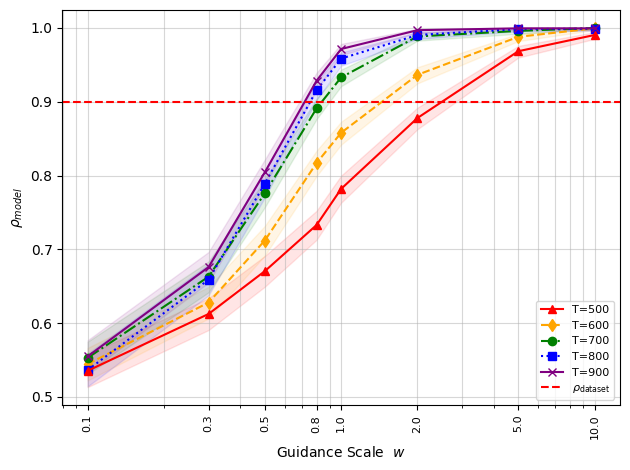

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Provided guidance weights
w_values = [0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0]

styles = {
    "T_500":  {"color": "red",    "marker": "^", "linestyle": "-",  "linewidth": 1.5, "zorder": 10},
    "T_600":  {"color": "orange", "marker": "d", "linestyle": "--", "linewidth": 1.5},
    "T_700":  {"color": "green",  "marker": "o", "linestyle": "-.", "linewidth": 1.5},
    "T_800":  {"color": "blue",   "marker": "s", "linestyle": ":",  "linewidth": 1.5},
    "T_900":  {"color": "purple", "marker": "x", "linestyle": "-",  "linewidth": 1.5},
    # "T_1000": {"color": "brown",  "marker": "v", "linestyle": "--", "linewidth": 1.5},
}


for label, entries in results.items():
    entries = sorted(entries, key=lambda x: float(x['guidance'].split('_')[1]))
    w = np.array([float(e['guidance'].split('_')[1]) for e in entries])
    rho = np.array([e['rho'] for e in entries])
    conf_low = np.array([e['conf_low'] for e in entries])
    conf_high = np.array([e['conf_high'] for e in entries])
    style = styles.get(label, {})
    legend_label = label.replace("T_", "T=")
    plt.plot(w, rho, label=legend_label, **style)
    plt.fill_between(w, conf_low, conf_high, alpha=0.1, color=style.get("color", "gray"))

# Reference horizontal line with legend
plt.axhline(0.9, color='red', linestyle='--', linewidth=1.5, label=r'$\rho_\text{dataset}$')

plt.xscale('log')
plt.xticks(w_values, [str(w) for w in w_values], fontsize=8, rotation=90)
plt.xlabel(r'Guidance Scale $\ w$', fontsize=10)
plt.ylabel(r'$\rho_{model}$', fontsize=10)
plt.legend(fontsize=8, loc='lower right', frameon=True)
# plt.ylim(0.75, 1.01)
plt.grid(True, alpha=0.5, which='both')
plt.tight_layout()
# plt.title(f"Biased MNIST CDPM {SAMPLER_EXP.split('/')[0]}", fontsize=12)
# plt.savefig("rho_vs_guidance_per_timestep_bmnist.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()


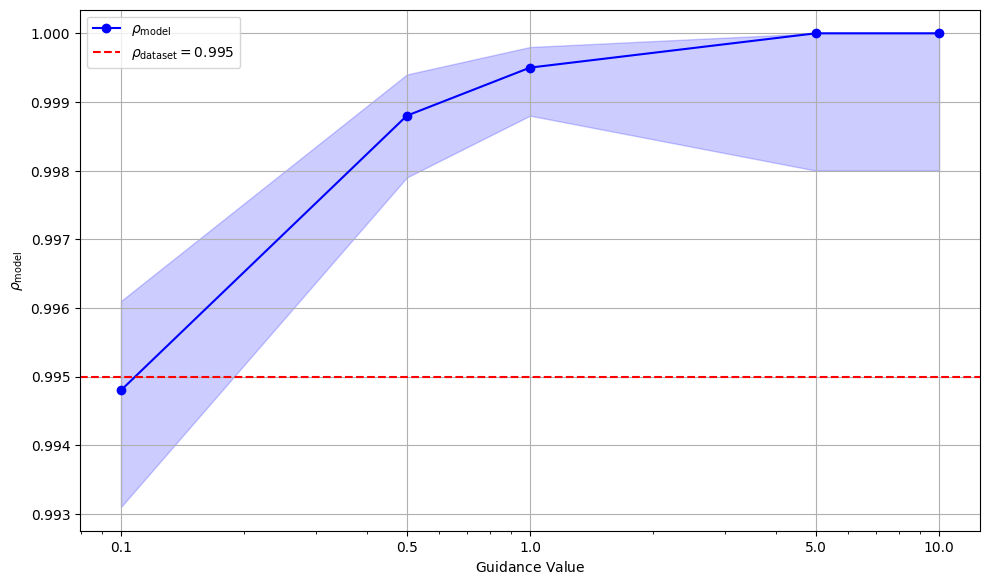

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

# Example Data
data = {
    'guidance_value': [0.1, 0.5, 1.0, 5.0, 10.0],
    'rho_estimate': [0.9948, 0.9988, 0.9995, 1.0, 1.0],
    'rho_low': [0.9931, 0.9979, 0.9988, 0.998, 0.998],
    'rho_high': [0.9961, 0.9994, 0.9998, 1.0, 1.0]
}


df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))

# Plot the shaded confidence interval
plt.fill_between(df['guidance_value'], df['rho_low'], df['rho_high'], 
                 color='blue', alpha=0.2)

# Plot the main line for the rho estimate
plt.plot(df['guidance_value'], df['rho_estimate'], 'o-', color='blue', label=r"$\rho_\text{model}$")

# plt.xscale('log')
# Axis labels using LaTeX style
plt.xlabel(r"$\text{Guidance Value}$")
plt.ylabel(r"$\rho_\text{model}$")

plt.axhline(y=0.995, color='red', linestyle='--', label=r"$\rho_\text{dataset}=0.995$")

plt.legend()
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
# plt.ylim(0, 1)
plt.xticks(df['guidance_value'], labels=df['guidance_value'])
plt.show()

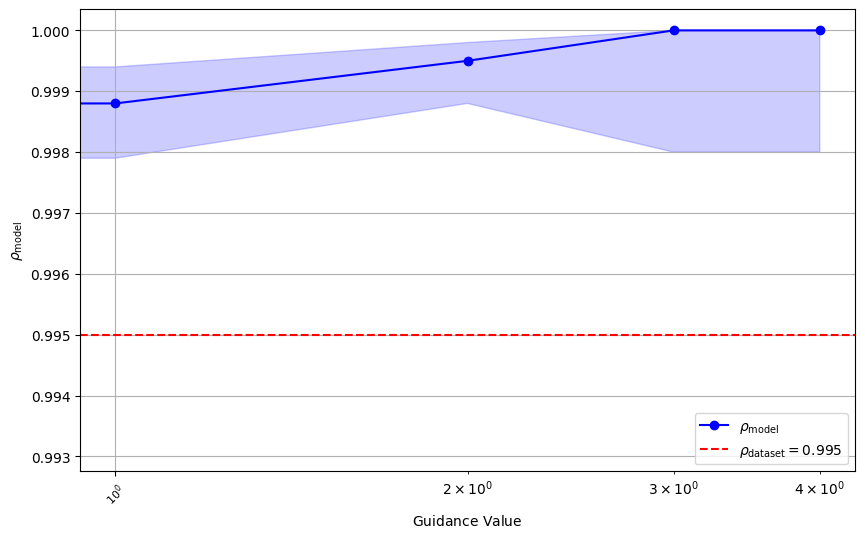

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Example Data (same as above)
data = {
    'guidance_value': ["0.1", "0.5", "1.0", "5.0", "10.0"],
    'rho_estimate': [0.9948, 0.9988, 0.9995, 1.0, 1.0],
    'rho_low': [0.9931, 0.9979, 0.9988, 0.998, 0.998],
    'rho_high': [0.9961, 0.9994, 0.9998, 1.0, 1.0]
}


df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))

# Shaded confidence interval
plt.fill_between(df['guidance_value'], df['rho_low'], df['rho_high'], 
                 alpha=0.2, color='blue') 

# Main line for the rho estimate
plt.plot(df['guidance_value'], df['rho_estimate'], 'o-', color='blue', label=r"$\rho_\text{model}$")

# Horizontal line for reference rho
plt.axhline(y=0.995, color='red', linestyle='--', label=r"$\rho_\text{dataset}=0.995$")

# Axis labels using LaTeX style
plt.xlabel(r"$\text{Guidance Value}$")
plt.ylabel(r"$\rho_\text{model}$")

# Ticks style
plt.xticks(df['guidance_value'], rotation=45, fontsize=8)

plt.xscale('log')

# Grid and legend
plt.grid()
plt.legend(loc='lower right')

# Save (optional)
plt.savefig("your_path_here.pdf", bbox_inches='tight', format="pdf", dpi=300)

plt.show()


## EVALUATION CODE FOR BMNIST

In [ ]:
"""
Loads images from a folder and analyzes the class-bias distribution, saving the results in a matrix.
The matrix is saved as a CSV file, and a configuration file is created with the parameters used for analysis.

The images should be in a folder with class information in the filename (e.g., class_0_xxx.png, class_1_xxx.png).
For each image, we compute the color index which corresponds to the bias label.
"""

import os
import glob
import numpy as np
import torch
from PIL import Image
import tqdm
import re

import himyb.datasets.biased_mnist_utils as biased_mnist_utils


def dump_dict_to_file(dump_dict, file_name):
    with open(file_name, "w", encoding="utf-8") as f:
        for key, value in dump_dict.items():
            f.write(f"{key}: {value}\n")


def extract_class_from_filename(filename):
    """
    Extract class number from filename.
    Assumes filename contains 'class_X' where X is the class number.
    """
    match = re.search(r'class(\d+)', filename)
    if match:
        return int(match.group(1))
    return None


def load_image_as_tensor(image_path):
    """
    Load an image and convert it to the format expected by biased_mnist_utils.
    Assumes images are in standard format (RGB, 0-255) and converts to the expected format.
    """
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert to tensor and normalize to [0, 1] range
    img_array = np.array(img).astype(np.float32) / 255.0
    
    # Convert to tensor and rearrange dimensions from HWC to CHW
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)
    
    return img_tensor


# Configuration

NUM_CLASSES = 2  # (0 and 1)
ROOT_DIR = "/home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned"  # <--- IMPORTANT: Update this path
RUN_NAMES = [
    f"T_{t}/w_{w}" 
    for t in range(500, 1001, 100)
    for w in ["0.1", "0.3", "0.5", "0.8", "1.0", "2.0", "5.0", "10.0"]
]

SAMPLER_EXP = "dpmsolver++_50steps_ord3/bmnist"  # Change this to your sampler experiment subfolder name

for run_name in RUN_NAMES:
    run_name = os.path.join(ROOT_DIR, SAMPLER_EXP, run_name)
    # Create output folder if it doesn't exist
    os.makedirs(run_name, exist_ok=True)

    # File paths for output
    save_file_name = "generated_color_matrix"
    matrix_file = os.path.join(run_name, f"{save_file_name}.csv")
    config_file = os.path.join(run_name, f"{save_file_name}_config.txt")

    # Get all image files
    image_extensions = ['*.png', '*.jpg', '*.jpeg']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(run_name, ext)))

    print(f"Found {len(image_files)} images to analyze")

    # Initialize matrix: rows are classes, columns are bias colors
    # Note: Using NUM_CLASSES instead of NUM_CLASSES + 1 since we don't have unconditional class
    matrix = np.zeros((NUM_CLASSES, NUM_CLASSES)).astype(int)

    # Process images
    valid_images = 0
    invalid_images = 0

    for image_path in tqdm.tqdm(image_files, desc="Processing images"):
        try:
            # Extract class from filename
            filename = os.path.basename(image_path)
            class_label = extract_class_from_filename(filename)
            # print(f"Processing {filename}, extracted class: {class_label}")

            if class_label is None:
                print(f"Warning: Could not extract class from filename: {filename}")
                invalid_images += 1
                continue
                
            if class_label >= NUM_CLASSES:
                print(f"Warning: Class {class_label} exceeds expected number of classes ({NUM_CLASSES})")
                invalid_images += 1
                continue
            
            # Load image and convert to tensor
            img_tensor = load_image_as_tensor(image_path)
            
            # Add batch dimension for compatibility with biased_mnist_utils
            img_batch = img_tensor.unsqueeze(0)
            
            # Get color index (bias label)
            color_idx = biased_mnist_utils.get_color_idx_from_batch(img_batch, allowed_colors=[0, 1]).cpu().numpy()[0]
            # print(f"Color index for {filename}: {color_idx}")
            
            # Update matrix
            matrix[class_label, color_idx] += 1
            valid_images += 1
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            invalid_images += 1
            continue

    print(f"Successfully processed {valid_images} images")
    print(f"Failed to process {invalid_images} images")

    # Save matrix
    np.savetxt(matrix_file, matrix, delimiter=",")
    print(f"Matrix saved to: {matrix_file}")

    # Save configuration
    config_dict = {
        "images_folder": run_name,
        "output_folder": run_name,
        "num_classes": NUM_CLASSES,
        "total_images_found": len(image_files),
        "valid_images_processed": valid_images,
        "invalid_images": invalid_images,
        "matrix_shape": f"{matrix.shape[0]}x{matrix.shape[1]}",
    }

    dump_dict_to_file(config_dict, config_file)
    print(f"Configuration saved to: {config_file}")

    # Display matrix
    print("\nClass-Bias Distribution Matrix:")
    print("Rows: Classes, Columns: Bias colors")
    print(matrix)

    # Calculate and display statistics
    print(f"\nStatistics:")
    for class_idx in range(NUM_CLASSES):
        total_class_samples = matrix[class_idx, :].sum()
        if total_class_samples > 0:
            print(f"Class {class_idx}: {total_class_samples} samples")
            for bias_idx in range(NUM_CLASSES):
                proportion = matrix[class_idx, bias_idx] / total_class_samples
                print(f"  Bias {bias_idx}: {matrix[class_idx, bias_idx]} samples ({proportion:.2%})")

Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2423.91it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_0.1/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_0.1/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[448 552]
 [414 586]]

Statistics:
Class 0: 1000 samples
  Bias 0: 448 samples (44.80%)
  Bias 1: 552 samples (55.20%)
Class 1: 1000 samples
  Bias 0: 414 samples (41.40%)
  Bias 1: 586 samples (58.60%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2450.40it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_0.3/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_0.3/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[508 492]
 [329 671]]

Statistics:
Class 0: 1000 samples
  Bias 0: 508 samples (50.80%)
  Bias 1: 492 samples (49.20%)
Class 1: 1000 samples
  Bias 0: 329 samples (32.90%)
  Bias 1: 671 samples (67.10%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2448.22it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_0.5/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_0.5/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[558 442]
 [276 724]]

Statistics:
Class 0: 1000 samples
  Bias 0: 558 samples (55.80%)
  Bias 1: 442 samples (44.20%)
Class 1: 1000 samples
  Bias 0: 276 samples (27.60%)
  Bias 1: 724 samples (72.40%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2437.64it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_0.8/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_0.8/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[694 306]
 [175 825]]

Statistics:
Class 0: 1000 samples
  Bias 0: 694 samples (69.40%)
  Bias 1: 306 samples (30.60%)
Class 1: 1000 samples
  Bias 0: 175 samples (17.50%)
  Bias 1: 825 samples (82.50%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2454.68it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_1.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_1.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[743 257]
 [149 851]]

Statistics:
Class 0: 1000 samples
  Bias 0: 743 samples (74.30%)
  Bias 1: 257 samples (25.70%)
Class 1: 1000 samples
  Bias 0: 149 samples (14.90%)
  Bias 1: 851 samples (85.10%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2443.76it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_2.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_2.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[919  81]
 [ 79 921]]

Statistics:
Class 0: 1000 samples
  Bias 0: 919 samples (91.90%)
  Bias 1: 81 samples (8.10%)
Class 1: 1000 samples
  Bias 0: 79 samples (7.90%)
  Bias 1: 921 samples (92.10%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2429.88it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_5.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_5.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[994   6]
 [ 35 965]]

Statistics:
Class 0: 1000 samples
  Bias 0: 994 samples (99.40%)
  Bias 1: 6 samples (0.60%)
Class 1: 1000 samples
  Bias 0: 35 samples (3.50%)
  Bias 1: 965 samples (96.50%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2463.50it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_10.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_500/w_10.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[999   1]
 [ 22 978]]

Statistics:
Class 0: 1000 samples
  Bias 0: 999 samples (99.90%)
  Bias 1: 1 samples (0.10%)
Class 1: 1000 samples
  Bias 0: 22 samples (2.20%)
  Bias 1: 978 samples (97.80%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2447.73it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_0.1/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_0.1/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[660 340]
 [592 408]]

Statistics:
Class 0: 1000 samples
  Bias 0: 660 samples (66.00%)
  Bias 1: 340 samples (34.00%)
Class 1: 1000 samples
  Bias 0: 592 samples (59.20%)
  Bias 1: 408 samples (40.80%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2439.51it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_0.3/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_0.3/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[732 268]
 [445 555]]

Statistics:
Class 0: 1000 samples
  Bias 0: 732 samples (73.20%)
  Bias 1: 268 samples (26.80%)
Class 1: 1000 samples
  Bias 0: 445 samples (44.50%)
  Bias 1: 555 samples (55.50%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2453.01it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_0.5/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_0.5/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[825 175]
 [400 600]]

Statistics:
Class 0: 1000 samples
  Bias 0: 825 samples (82.50%)
  Bias 1: 175 samples (17.50%)
Class 1: 1000 samples
  Bias 0: 400 samples (40.00%)
  Bias 1: 600 samples (60.00%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2435.48it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_0.8/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_0.8/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[900 100]
 [272 728]]

Statistics:
Class 0: 1000 samples
  Bias 0: 900 samples (90.00%)
  Bias 1: 100 samples (10.00%)
Class 1: 1000 samples
  Bias 0: 272 samples (27.20%)
  Bias 1: 728 samples (72.80%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2418.48it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_1.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_1.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[939  61]
 [208 792]]

Statistics:
Class 0: 1000 samples
  Bias 0: 939 samples (93.90%)
  Bias 1: 61 samples (6.10%)
Class 1: 1000 samples
  Bias 0: 208 samples (20.80%)
  Bias 1: 792 samples (79.20%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2456.28it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_2.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_2.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[996   4]
 [ 85 915]]

Statistics:
Class 0: 1000 samples
  Bias 0: 996 samples (99.60%)
  Bias 1: 4 samples (0.40%)
Class 1: 1000 samples
  Bias 0: 85 samples (8.50%)
  Bias 1: 915 samples (91.50%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2454.31it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_5.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_5.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[1000    0]
 [  26  974]]

Statistics:
Class 0: 1000 samples
  Bias 0: 1000 samples (100.00%)
  Bias 1: 0 samples (0.00%)
Class 1: 1000 samples
  Bias 0: 26 samples (2.60%)
  Bias 1: 974 samples (97.40%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2447.32it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_10.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_600/w_10.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[1000    0]
 [  11  989]]

Statistics:
Class 0: 1000 samples
  Bias 0: 1000 samples (100.00%)
  Bias 1: 0 samples (0.00%)
Class 1: 1000 samples
  Bias 0: 11 samples (1.10%)
  Bias 1: 989 samples (98.90%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2450.12it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_0.1/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_0.1/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[560 440]
 [467 533]]

Statistics:
Class 0: 1000 samples
  Bias 0: 560 samples (56.00%)
  Bias 1: 440 samples (44.00%)
Class 1: 1000 samples
  Bias 0: 467 samples (46.70%)
  Bias 1: 533 samples (53.30%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2452.92it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_0.3/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_0.3/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[636 364]
 [369 631]]

Statistics:
Class 0: 1000 samples
  Bias 0: 636 samples (63.60%)
  Bias 1: 364 samples (36.40%)
Class 1: 1000 samples
  Bias 0: 369 samples (36.90%)
  Bias 1: 631 samples (63.10%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2409.01it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_0.5/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_0.5/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[706 294]
 [294 706]]

Statistics:
Class 0: 1000 samples
  Bias 0: 706 samples (70.60%)
  Bias 1: 294 samples (29.40%)
Class 1: 1000 samples
  Bias 0: 294 samples (29.40%)
  Bias 1: 706 samples (70.60%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2450.47it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_0.8/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_0.8/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[841 159]
 [167 833]]

Statistics:
Class 0: 1000 samples
  Bias 0: 841 samples (84.10%)
  Bias 1: 159 samples (15.90%)
Class 1: 1000 samples
  Bias 0: 167 samples (16.70%)
  Bias 1: 833 samples (83.30%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2410.62it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_1.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_1.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[887 113]
 [107 893]]

Statistics:
Class 0: 1000 samples
  Bias 0: 887 samples (88.70%)
  Bias 1: 113 samples (11.30%)
Class 1: 1000 samples
  Bias 0: 107 samples (10.70%)
  Bias 1: 893 samples (89.30%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2453.66it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_2.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_2.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[988  12]
 [ 18 982]]

Statistics:
Class 0: 1000 samples
  Bias 0: 988 samples (98.80%)
  Bias 1: 12 samples (1.20%)
Class 1: 1000 samples
  Bias 0: 18 samples (1.80%)
  Bias 1: 982 samples (98.20%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2453.13it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_5.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_5.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[1000    0]
 [   0 1000]]

Statistics:
Class 0: 1000 samples
  Bias 0: 1000 samples (100.00%)
  Bias 1: 0 samples (0.00%)
Class 1: 1000 samples
  Bias 0: 0 samples (0.00%)
  Bias 1: 1000 samples (100.00%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2460.21it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_10.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_700/w_10.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[1000    0]
 [   0 1000]]

Statistics:
Class 0: 1000 samples
  Bias 0: 1000 samples (100.00%)
  Bias 1: 0 samples (0.00%)
Class 1: 1000 samples
  Bias 0: 0 samples (0.00%)
  Bias 1: 1000 samples (100.00%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2415.71it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_0.1/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_0.1/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[564 436]
 [531 469]]

Statistics:
Class 0: 1000 samples
  Bias 0: 564 samples (56.40%)
  Bias 1: 436 samples (43.60%)
Class 1: 1000 samples
  Bias 0: 531 samples (53.10%)
  Bias 1: 469 samples (46.90%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2449.18it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_0.3/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_0.3/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[643 357]
 [449 551]]

Statistics:
Class 0: 1000 samples
  Bias 0: 643 samples (64.30%)
  Bias 1: 357 samples (35.70%)
Class 1: 1000 samples
  Bias 0: 449 samples (44.90%)
  Bias 1: 551 samples (55.10%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2449.94it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_0.5/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_0.5/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[716 284]
 [313 687]]

Statistics:
Class 0: 1000 samples
  Bias 0: 716 samples (71.60%)
  Bias 1: 284 samples (28.40%)
Class 1: 1000 samples
  Bias 0: 313 samples (31.30%)
  Bias 1: 687 samples (68.70%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2442.52it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_0.8/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_0.8/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[857 143]
 [213 787]]

Statistics:
Class 0: 1000 samples
  Bias 0: 857 samples (85.70%)
  Bias 1: 143 samples (14.30%)
Class 1: 1000 samples
  Bias 0: 213 samples (21.30%)
  Bias 1: 787 samples (78.70%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2443.60it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_1.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_1.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[906  94]
 [161 839]]

Statistics:
Class 0: 1000 samples
  Bias 0: 906 samples (90.60%)
  Bias 1: 94 samples (9.40%)
Class 1: 1000 samples
  Bias 0: 161 samples (16.10%)
  Bias 1: 839 samples (83.90%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2434.60it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_2.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_2.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[994   6]
 [ 48 952]]

Statistics:
Class 0: 1000 samples
  Bias 0: 994 samples (99.40%)
  Bias 1: 6 samples (0.60%)
Class 1: 1000 samples
  Bias 0: 48 samples (4.80%)
  Bias 1: 952 samples (95.20%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2427.67it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_5.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_5.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[1000    0]
 [   1  999]]

Statistics:
Class 0: 1000 samples
  Bias 0: 1000 samples (100.00%)
  Bias 1: 0 samples (0.00%)
Class 1: 1000 samples
  Bias 0: 1 samples (0.10%)
  Bias 1: 999 samples (99.90%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2451.34it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_10.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_800/w_10.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[1000    0]
 [   0 1000]]

Statistics:
Class 0: 1000 samples
  Bias 0: 1000 samples (100.00%)
  Bias 1: 0 samples (0.00%)
Class 1: 1000 samples
  Bias 0: 0 samples (0.00%)
  Bias 1: 1000 samples (100.00%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2445.75it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_0.1/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_0.1/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[543 457]
 [506 494]]

Statistics:
Class 0: 1000 samples
  Bias 0: 543 samples (54.30%)
  Bias 1: 457 samples (45.70%)
Class 1: 1000 samples
  Bias 0: 506 samples (50.60%)
  Bias 1: 494 samples (49.40%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2429.20it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_0.3/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_0.3/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[646 354]
 [407 593]]

Statistics:
Class 0: 1000 samples
  Bias 0: 646 samples (64.60%)
  Bias 1: 354 samples (35.40%)
Class 1: 1000 samples
  Bias 0: 407 samples (40.70%)
  Bias 1: 593 samples (59.30%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2422.32it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_0.5/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_0.5/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[712 288]
 [327 673]]

Statistics:
Class 0: 1000 samples
  Bias 0: 712 samples (71.20%)
  Bias 1: 288 samples (28.80%)
Class 1: 1000 samples
  Bias 0: 327 samples (32.70%)
  Bias 1: 673 samples (67.30%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2440.66it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_0.8/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_0.8/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[819 181]
 [202 798]]

Statistics:
Class 0: 1000 samples
  Bias 0: 819 samples (81.90%)
  Bias 1: 181 samples (18.10%)
Class 1: 1000 samples
  Bias 0: 202 samples (20.20%)
  Bias 1: 798 samples (79.80%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2392.43it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_1.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_1.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[893 107]
 [156 844]]

Statistics:
Class 0: 1000 samples
  Bias 0: 893 samples (89.30%)
  Bias 1: 107 samples (10.70%)
Class 1: 1000 samples
  Bias 0: 156 samples (15.60%)
  Bias 1: 844 samples (84.40%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2450.90it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_2.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_2.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[989  11]
 [ 48 952]]

Statistics:
Class 0: 1000 samples
  Bias 0: 989 samples (98.90%)
  Bias 1: 11 samples (1.10%)
Class 1: 1000 samples
  Bias 0: 48 samples (4.80%)
  Bias 1: 952 samples (95.20%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2459.06it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_5.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_5.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[1000    0]
 [   7  993]]

Statistics:
Class 0: 1000 samples
  Bias 0: 1000 samples (100.00%)
  Bias 1: 0 samples (0.00%)
Class 1: 1000 samples
  Bias 0: 7 samples (0.70%)
  Bias 1: 993 samples (99.30%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2455.22it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_10.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_900/w_10.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[1000    0]
 [   0 1000]]

Statistics:
Class 0: 1000 samples
  Bias 0: 1000 samples (100.00%)
  Bias 1: 0 samples (0.00%)
Class 1: 1000 samples
  Bias 0: 0 samples (0.00%)
  Bias 1: 1000 samples (100.00%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2463.21it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_0.1/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_0.1/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[547 453]
 [413 587]]

Statistics:
Class 0: 1000 samples
  Bias 0: 547 samples (54.70%)
  Bias 1: 453 samples (45.30%)
Class 1: 1000 samples
  Bias 0: 413 samples (41.30%)
  Bias 1: 587 samples (58.70%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2472.56it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_0.3/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_0.3/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[623 377]
 [359 641]]

Statistics:
Class 0: 1000 samples
  Bias 0: 623 samples (62.30%)
  Bias 1: 377 samples (37.70%)
Class 1: 1000 samples
  Bias 0: 359 samples (35.90%)
  Bias 1: 641 samples (64.10%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2425.76it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_0.5/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_0.5/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[709 291]
 [335 665]]

Statistics:
Class 0: 1000 samples
  Bias 0: 709 samples (70.90%)
  Bias 1: 291 samples (29.10%)
Class 1: 1000 samples
  Bias 0: 335 samples (33.50%)
  Bias 1: 665 samples (66.50%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2431.33it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_0.8/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_0.8/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[840 160]
 [199 801]]

Statistics:
Class 0: 1000 samples
  Bias 0: 840 samples (84.00%)
  Bias 1: 160 samples (16.00%)
Class 1: 1000 samples
  Bias 0: 199 samples (19.90%)
  Bias 1: 801 samples (80.10%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2461.47it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_1.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_1.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[883 117]
 [151 849]]

Statistics:
Class 0: 1000 samples
  Bias 0: 883 samples (88.30%)
  Bias 1: 117 samples (11.70%)
Class 1: 1000 samples
  Bias 0: 151 samples (15.10%)
  Bias 1: 849 samples (84.90%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2470.97it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_2.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_2.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[989  11]
 [ 40 960]]

Statistics:
Class 0: 1000 samples
  Bias 0: 989 samples (98.90%)
  Bias 1: 11 samples (1.10%)
Class 1: 1000 samples
  Bias 0: 40 samples (4.00%)
  Bias 1: 960 samples (96.00%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2471.85it/s]


Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_5.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_5.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[ 999    1]
 [   0 1000]]

Statistics:
Class 0: 1000 samples
  Bias 0: 999 samples (99.90%)
  Bias 1: 1 samples (0.10%)
Class 1: 1000 samples
  Bias 0: 0 samples (0.00%)
  Bias 1: 1000 samples (100.00%)
Found 2000 images to analyze


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2472.17it/s]

Successfully processed 2000 images
Failed to process 0 images
Matrix saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_10.0/generated_color_matrix.csv
Configuration saved to: /home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned/dpmsolver++_50steps_ord3/bmnist/T_1000/w_10.0/generated_color_matrix_config.txt

Class-Bias Distribution Matrix:
Rows: Classes, Columns: Bias colors
[[1000    0]
 [   0 1000]]

Statistics:
Class 0: 1000 samples
  Bias 0: 1000 samples (100.00%)
  Bias 1: 0 samples (0.00%)
Class 1: 1000 samples
  Bias 0: 0 samples (0.00%)
  Bias 1: 1000 samples (100.00%)


In [ ]:

ROOT_DIR = "/home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/GenImages/conditioned"  # <--- IMPORTANT: Update this path
RUN_NAMES = [
    f"T_{t}/w_{w}" 
    for t in range(500, 1001, 100)
    for w in ["0.1", "0.3", "0.5", "0.8", "1.0", "2.0", "5.0", "10.0"]
]

guidance_values = ["w_0.1", "w_0.3", "w_0.5", "w_0.8", "w_1.0", "w_2.0", "w_5.0", "w_10.0"]

results = { "T_500": [], "T_600": [], "T_700": [], "T_800": [], "T_900": [], "T_1000": [] }

# SAMPLER_EXP = "dpmsolver_10steps_ord2"  # Change this to your sampler experiment subfolder name

for run_name in RUN_NAMES:
    matrix_file_path = f"{ROOT_DIR}/{SAMPLER_EXP}/{run_name}/generated_color_matrix.csv"
    matrix = np.loadtxt(matrix_file_path, delimiter=',')
    # take the first part of run name path as the key
    run_key = run_name.split('/')[0]  # e.g., "T_500"
    gv = run_name.split('/')[-1]  # e.g., "w_0.1"
    estimated_rho, confidence_interval = get_rho_confidence_interval(matrix)
    results[run_key].append({
        "guidance": gv,
        "rho": estimated_rho,
        "conf_low": confidence_interval[0],
        "conf_high": confidence_interval[1]
    })
    # Print results
    print(f"Run: {run_key}, Guidance: {gv}")
    print(f"  Estimated rho: {estimated_rho:.4f}")
    print(f"  Confidence interval: {confidence_interval[0]:.4f} - {confidence_interval[1]:.4f}\n")

Run: T_500, Guidance: w_0.1
  Estimated rho: 0.5170
  Confidence interval: 0.4948 - 0.5391

Run: T_500, Guidance: w_0.3
  Estimated rho: 0.5895
  Confidence interval: 0.5676 - 0.6112

Run: T_500, Guidance: w_0.5
  Estimated rho: 0.6410
  Confidence interval: 0.6195 - 0.6621

Run: T_500, Guidance: w_0.8
  Estimated rho: 0.7595
  Confidence interval: 0.7401 - 0.7781

Run: T_500, Guidance: w_1.0
  Estimated rho: 0.7970
  Confidence interval: 0.7787 - 0.8144

Run: T_500, Guidance: w_2.0
  Estimated rho: 0.9200
  Confidence interval: 0.9072 - 0.9315

Run: T_500, Guidance: w_5.0
  Estimated rho: 0.9795
  Confidence interval: 0.9723 - 0.9852

Run: T_500, Guidance: w_10.0
  Estimated rho: 0.9885
  Confidence interval: 0.9828 - 0.9927

Run: T_600, Guidance: w_0.1
  Estimated rho: 0.5340
  Confidence interval: 0.5119 - 0.5560

Run: T_600, Guidance: w_0.3
  Estimated rho: 0.6435
  Confidence interval: 0.6221 - 0.6645

Run: T_600, Guidance: w_0.5
  Estimated rho: 0.7125
  Confidence interval: 0.69

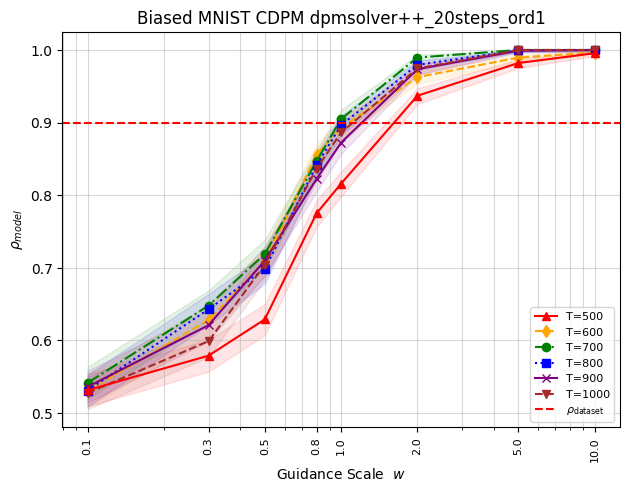

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Provided guidance weights
w_values = [0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0]

styles = {
    "T_500":  {"color": "red",    "marker": "^", "linestyle": "-",  "linewidth": 1.5, "zorder": 10},
    "T_600":  {"color": "orange", "marker": "d", "linestyle": "--", "linewidth": 1.5},
    "T_700":  {"color": "green",  "marker": "o", "linestyle": "-.", "linewidth": 1.5},
    "T_800":  {"color": "blue",   "marker": "s", "linestyle": ":",  "linewidth": 1.5},
    "T_900":  {"color": "purple", "marker": "x", "linestyle": "-",  "linewidth": 1.5},
    "T_1000": {"color": "brown",  "marker": "v", "linestyle": "--", "linewidth": 1.5},
}

for label, entries in results.items():
    entries = sorted(entries, key=lambda x: float(x['guidance'].split('_')[1]))
    w = np.array([float(e['guidance'].split('_')[1]) for e in entries])
    rho = np.array([e['rho'] for e in entries])
    conf_low = np.array([e['conf_low'] for e in entries])
    conf_high = np.array([e['conf_high'] for e in entries])
    style = styles.get(label, {})
    legend_label = label.replace("T_", "T=")
    plt.plot(w, rho, label=legend_label, **style)
    plt.fill_between(w, conf_low, conf_high, alpha=0.1, color=style.get("color", "gray"))

# Reference horizontal line with legend
plt.axhline(0.9, color='red', linestyle='--', linewidth=1.5, label=r'$\rho_\text{dataset}$')

plt.xscale('log')
plt.xticks(w_values, [str(w) for w in w_values], fontsize=8, rotation=90)
plt.xlabel(r'Guidance Scale $\ w$', fontsize=10)
plt.ylabel(r'$\rho_{model}$', fontsize=10)
plt.legend(fontsize=8, loc='lower right', frameon=True)
# plt.ylim(0.75, 1.01)
plt.grid(True, alpha=0.5, which='both')
plt.tight_layout()
plt.title(f"Biased MNIST CDPM {SAMPLER_EXP.split('/')[0]}", fontsize=12)
# plt.savefig("rho_vs_guidance_per_timestep_bmnist.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()


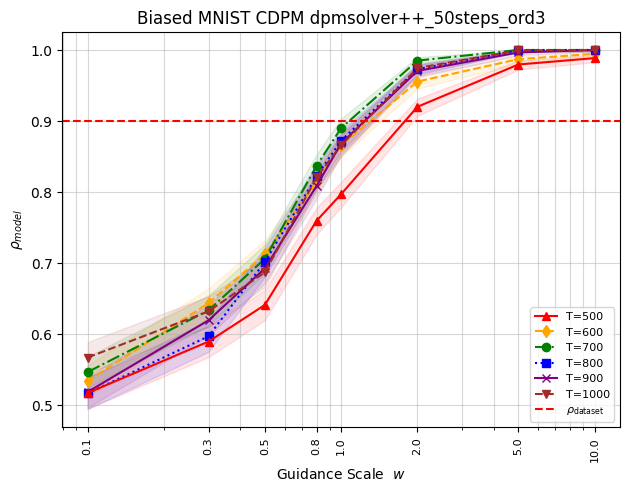

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Provided guidance weights
w_values = [0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0]

styles = {
    "T_500":  {"color": "red",    "marker": "^", "linestyle": "-",  "linewidth": 1.5, "zorder": 10},
    "T_600":  {"color": "orange", "marker": "d", "linestyle": "--", "linewidth": 1.5},
    "T_700":  {"color": "green",  "marker": "o", "linestyle": "-.", "linewidth": 1.5},
    "T_800":  {"color": "blue",   "marker": "s", "linestyle": ":",  "linewidth": 1.5},
    "T_900":  {"color": "purple", "marker": "x", "linestyle": "-",  "linewidth": 1.5},
    "T_1000": {"color": "brown",  "marker": "v", "linestyle": "--", "linewidth": 1.5},
}

# plt.figure(figsize=(8, 6))  

for label, entries in results.items():
    entries = sorted(entries, key=lambda x: float(x['guidance'].split('_')[1]))
    w = np.array([float(e['guidance'].split('_')[1]) for e in entries])
    rho = np.array([e['rho'] for e in entries])
    conf_low = np.array([e['conf_low'] for e in entries])
    conf_high = np.array([e['conf_high'] for e in entries])
    style = styles.get(label, {})
    legend_label = label.replace("T_", "T=")
    plt.plot(w, rho, label=legend_label, **style)
    plt.fill_between(w, conf_low, conf_high, alpha=0.1, color=style.get("color", "gray"))

# Reference horizontal line with legend
plt.axhline(0.9, color='red', linestyle='--', linewidth=1.5, label=r'$\rho_\text{dataset}$')

plt.xscale('log')
plt.xticks(w_values, [str(w) for w in w_values], fontsize=8, rotation=90)
plt.xlabel(r'Guidance Scale $\ w$', fontsize=10)
plt.ylabel(r'$\rho_{model}$', fontsize=10)
plt.legend(fontsize=8, loc='lower right', frameon=True)
# plt.ylim(0.75, 1.01)
plt.grid(True, alpha=0.5, which='both')
plt.tight_layout()
plt.title(f"Biased MNIST CDPM {SAMPLER_EXP.split('/')[0]}", fontsize=12)
# plt.savefig("rho_vs_guidance_per_timestep_bmnist.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()


In [34]:
baseline_std = [0.3180, 0.3266, 0.3242]

# Define noise levels
noise_levels = {
    "very_low":   [s * 0.25 for s in baseline_std],
    "low":        [s * 0.50 for s in baseline_std],
    "medium":     [s * 0.75 for s in baseline_std],
    "baseline":   baseline_std,
    "high":       [s * 1.25 for s in baseline_std],
    "very_high":  [s * 1.50 for s in baseline_std],
}

print("Noise Level Configurations:")
for level, stds in noise_levels.items():
    print(f"{level}: stds = {[round(s, 4) for s in stds]}")

Noise Level Configurations:
very_low: stds = [0.0795, 0.0817, 0.081]
low: stds = [0.159, 0.1633, 0.1621]
medium: stds = [0.2385, 0.245, 0.2431]
baseline: stds = [0.318, 0.3266, 0.3242]
high: stds = [0.3975, 0.4083, 0.4052]
very_high: stds = [0.477, 0.4899, 0.4863]


In [ ]:
# import gdown
# import zipfile
# import os

# def download_and_unzip(gdrive_url, output_dir="/data05/ani", unzip=True):
#     """
#     Downloads a file from Google Drive and optionally unzips it.

#     Args:
#         gdrive_url (str): The Google Drive shareable link (can be 'uc?id=...' or normal link).
#         output_dir (str): Where to save/unzip the file.
#         unzip (bool): Whether to unzip after download.

#     Returns:
#         str: Path to downloaded (or unzipped) file/folder.
#     """
#     os.makedirs(output_dir, exist_ok=True)

#     # Extract file ID from link if needed
#     if "drive.google.com" in gdrive_url and "uc?id=" not in gdrive_url:
#         # Convert standard share link to direct download
#         file_id = gdrive_url.split("/d/")[1].split("/")[0]
#         gdrive_url = f"https://drive.google.com/uc?id={file_id}"

#     # Download file
#     output_zip = os.path.join(output_dir, "downloaded.zip")
#     gdown.download(gdrive_url, output_zip, quiet=False)

#     # Unzip if required
#     if unzip:
#         with zipfile.ZipFile(output_zip, 'r') as zip_ref:
#             zip_ref.extractall(output_dir)
#         os.remove(output_zip)  # delete zip to save space
#         return output_dir
#     else:
#         return output_zip


# # Example usage
# gdrive_link = "https://drive.google.com/file/d/1_uTI8-C-kEO7jMTXKMSGicMbbP0P_AdI/view?usp=sharing"
# data_path = download_and_unzip(gdrive_link, output_dir="/data05/ani", unzip=True)
# print("Data available at:", data_path)


Downloading...
From (original): https://drive.google.com/uc?id=1_uTI8-C-kEO7jMTXKMSGicMbbP0P_AdI
From (redirected): https://drive.google.com/uc?id=1_uTI8-C-kEO7jMTXKMSGicMbbP0P_AdI&confirm=t&uuid=0b5fa7e6-fffa-474f-a5b3-42bdbf952208
To: /data05/ani/downloaded.zip
100%|██████████| 2.62G/2.62G [00:32<00:00, 81.5MB/s]


Data available at: /data05/ani


In [ ]:
import csv
import os
from collections import defaultdict
from scipy.stats import binomtest


def evaluate_predictions(csv_filename='predictions.csv', save_csv='metrics.csv', label="experiment"):
    """
    Evaluates the prediction accuracy from the CSV file, including fine-grained metrics
    and 95% Clopper-Pearson confidence intervals.
    Saves results to a CSV file for later reuse.
    """

    correct_gender = 0
    correct_age = 0
    total_predictions = 0

    # Fine-grained counters
    fine_counts = defaultdict(lambda: {'total': 0, 'correct': 0})

    # ---------------- READ CSV ----------------
    try:
        with open(csv_filename, mode='r', newline='') as file:
            reader = csv.reader(file)
            header = next(reader)

            gender_pred_idx = header.index('Gender Prediction')
            real_gender_idx = header.index('Real Gender')
            age_pred_idx = header.index('Age Prediction')
            real_age_idx = header.index('Real Age')

            for row in reader:
                total_predictions += 1

                real_combo = f"{row[real_age_idx]}-{row[real_gender_idx]}"
                pred_combo = f"{row[age_pred_idx]}-{row[gender_pred_idx]}"

                fine_counts[real_combo]['total'] += 1
                if real_combo == pred_combo:
                    fine_counts[real_combo]['correct'] += 1

                if row[gender_pred_idx] == row[real_gender_idx]:
                    correct_gender += 1

                if row[age_pred_idx] == row[real_age_idx]:
                    correct_age += 1

    except FileNotFoundError:
        print(f"Error: The file '{csv_filename}' was not found.")
        return

    # No predictions?
    if total_predictions == 0:
        print("No predictions to evaluate.")
        return

    # ---------------- COMPUTE METRICS ----------------
    gender_acc = (correct_gender / total_predictions) * 100
    age_acc = (correct_age / total_predictions) * 100

    gender_ci = binomtest(correct_gender, total_predictions).proportion_ci(confidence_level=0.95, method="exact")
    age_ci = binomtest(correct_age, total_predictions).proportion_ci(confidence_level=0.95, method="exact")

    # ---------------- PRINT RESULTS ----------------
    print("\n--- Evaluation Results ---")
    print(f"Total predictions evaluated: {total_predictions}")

    print(
        f"Gender Accuracy: {gender_acc:.2f}% "
        f"({correct_gender}/{total_predictions}), "
        f"95% CI: [{gender_ci.low*100:.2f}%, {gender_ci.high*100:.2f}%]"
    )

    print(
        f"Age Accuracy: {age_acc:.2f}% "
        f"({correct_age}/{total_predictions}), "
        f"95% CI: [{age_ci.low*100:.2f}%, {age_ci.high*100:.2f}%]"
    )

    # Compute pairwise metrics for saving + printing
    pair_results = {}
    print("\n--- Pair-Wise Accuracy ---")
    for combo in ['Young-Female', 'Young-Male', 'Old-Female', 'Old-Male']:
        total = fine_counts[combo]['total']
        correct = fine_counts[combo]['correct']
        acc = (correct / total * 100) if total > 0 else None

        if total > 0:
            ci = binomtest(correct, total).proportion_ci(confidence_level=0.95, method="exact")
            ci_low, ci_high = ci.low*100, ci.high*100

            print(f"{combo}: {acc:.2f}% ({correct}/{total}), "
                  f"95% CI: [{ci_low:.2f}%, {ci_high:.2f}%]")
        else:
            ci_low = ci_high = None
            print(f"{combo}: No samples")

        pair_results[combo] = (acc, ci_low, ci_high)

    # ---------------- SAVE TO METRICS CSV ----------------
    file_exists = os.path.exists(save_csv)

    with open(save_csv, mode='a', newline='') as f:
        writer = csv.writer(f)

        # Write header if needed
        if not file_exists:
            writer.writerow(["metric", "experiment", "acc", "ci_low", "ci_high"])

        # Overall metrics
        writer.writerow(["gender", label, gender_acc, gender_ci.low*100, gender_ci.high*100])
        writer.writerow(["age", label, age_acc, age_ci.low*100, age_ci.high*100])

        # Pairwise metrics
        for combo, (acc, ci_low, ci_high) in pair_results.items():
            metric_name = combo.lower().replace("-", "_")
            writer.writerow([metric_name, label, acc, ci_low, ci_high])

    print(f"\nMetrics saved in: {save_csv}")


print("\n---------------------------WITHOUT NOISE-------------------------------")
evaluate_predictions(
    csv_filename='/home/ani/bias_ddpm/predictions.csv',
    label="no_noise"
)

print("\n---------------------------VERY LOW-------------------------------")
evaluate_predictions(
    csv_filename='/home/ani/bias_ddpm/predictions_noise_very_low.csv',
    label="very_low"
)

print("\n----------------------------LOW------------------------------")
evaluate_predictions(
    csv_filename='/home/ani/bias_ddpm/predictions_noise_low.csv',
    label="low"
)

print("\n---------------------------MEDIUM-------------------------------")
evaluate_predictions(
    csv_filename='/home/ani/bias_ddpm/predictions_noise_medium.csv',
    label="medium"
)

print("\n---------------------------BASELINE-----------------------------")
evaluate_predictions(
    csv_filename='/home/ani/bias_ddpm/predictions_noise_baseline.csv',
    label="baseline"
)

print("\n------------------------------HIGH----------------------------")
evaluate_predictions(
    csv_filename='/home/ani/bias_ddpm/predictions_noise_high.csv',
    label="high"
)

print("\n----------------------------VERY HIGH---------------------------")
evaluate_predictions(
    csv_filename='/home/ani/bias_ddpm/predictions_noise_very_high.csv',
    label="very_high"
)




---------------------------WITHOUT NOISE-------------------------------

--- Evaluation Results ---
Total predictions evaluated: 21200
Gender Accuracy: 98.70% (20925/21200), 95% CI: [98.54%, 98.85%]
Age Accuracy: 96.18% (20391/21200), 95% CI: [95.92%, 96.44%]

--- Pair-Wise Accuracy ---
Young-Female: 94.85% (9771/10302), 95% CI: [94.40%, 95.26%]
Young-Male: 94.30% (281/298), 95% CI: [91.02%, 96.64%]
Old-Female: 90.94% (271/298), 95% CI: [87.09%, 93.94%]
Old-Male: 95.14% (9801/10302), 95% CI: [94.70%, 95.54%]

---------------------------VERY LOW-------------------------------

--- Evaluation Results ---
Total predictions evaluated: 21200
Gender Accuracy: 98.75% (20935/21200), 95% CI: [98.59%, 98.90%]
Age Accuracy: 96.76% (20514/21200), 95% CI: [96.52%, 97.00%]

--- Pair-Wise Accuracy ---
Young-Female: 95.28% (9816/10302), 95% CI: [94.86%, 95.68%]
Young-Male: 93.29% (278/298), 95% CI: [89.82%, 95.85%]
Old-Female: 86.58% (258/298), 95% CI: [82.17%, 90.23%]
Old-Male: 96.14% (9904/10302), 

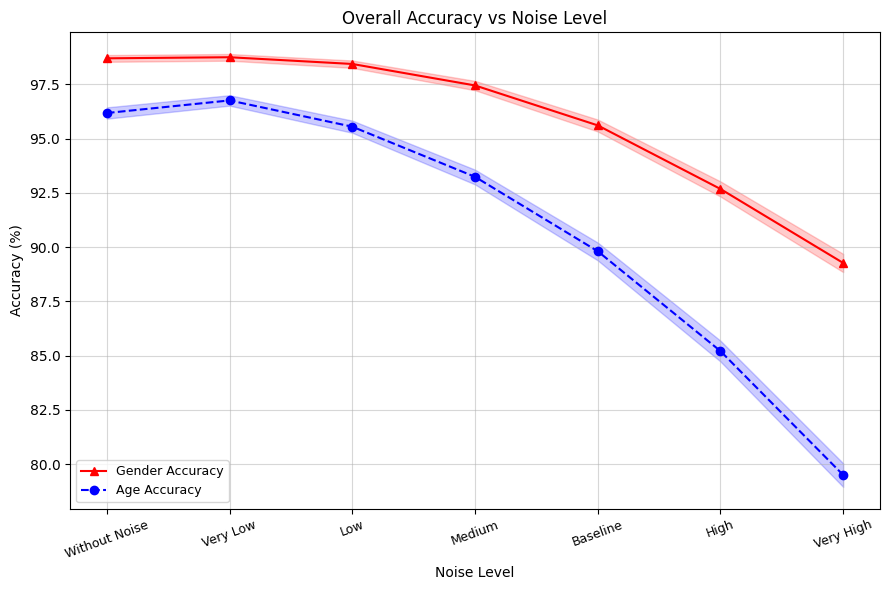

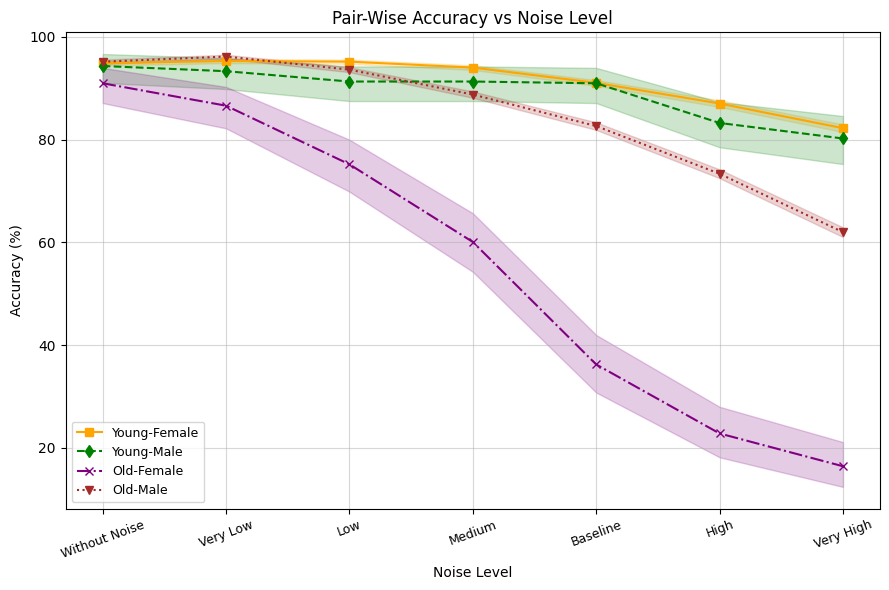

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Noise levels
noise_levels = ["Without Noise", "Very Low", "Low", "Medium", "Baseline", "High", "Very High"]
x = np.arange(len(noise_levels))

# Test
# ---------------- Overall Accuracies ----------------
gender_acc = [98.70, 98.75, 98.44, 97.45, 95.61, 92.68, 89.27]
gender_ci  = [(98.54, 98.85), (98.59, 98.90), (98.26, 98.60), (97.23, 97.66),
              (95.33, 95.88), (92.33, 93.03), (88.85, 89.69)]

age_acc = [96.18, 96.76, 95.55, 93.24, 89.81, 85.21, 79.50]
age_ci  = [(95.92, 96.44), (96.52, 97.00), (95.27, 95.83), (92.89, 93.57),
           (89.39, 90.21), (84.73, 85.69), (78.95, 80.04)]

# ---------------- Pair-wise Accuracies ----------------
young_female = [94.85, 95.28, 95.15, 94.00, 91.02, 87.00, 82.21]
young_female_ci = [(94.40, 95.26), (94.86, 95.68), (94.71, 95.55), (93.53, 94.45),
                   (90.45, 91.57), (86.34, 87.65), (81.45, 82.94)]

young_male = [94.30, 93.29, 91.28, 91.28, 90.94, 83.22, 80.20]
young_male_ci = [(91.02, 96.64), (89.82, 95.85), (87.48, 94.22), (87.48, 94.22),
                 (87.09, 93.94), (78.49, 87.28), (75.22, 84.57)]

old_female = [90.94, 86.58, 75.17, 60.07, 36.24, 22.82, 16.44]
old_female_ci = [(87.09, 93.94), (82.17, 90.23), (69.86, 79.97), (54.26, 65.67),
                 (30.78, 41.98), (18.18, 28.01), (12.42, 21.15)]

old_male = [95.14, 96.14, 93.59, 88.75, 82.62, 73.34, 61.98]
old_male_ci = [(94.70, 95.54), (95.75, 96.50), (93.10, 94.06), (88.12, 89.35),
               (81.87, 83.34), (72.48, 74.20), (61.03, 62.92)]

# import pandas as pd

# df = pd.read_csv("metrics.csv")

# # Estrarre una categoria
# def load_metric(df, metric_name):
#     subset = df[df["metric"] == metric_name]
#     acc = subset["acc"].tolist()
#     ci = list(zip(subset["ci_low"], subset["ci_high"]))
#     return acc, ci

# gender_acc, gender_ci = load_metric(df, "gender")
# young_male_acc, young_male_ci = load_metric(df, "young_male")

# print(gender_acc, gender_ci)


# --- Styles ---
styles_overall = {
    "Gender": {"color": "red", "marker": "^", "linestyle": "-", "linewidth": 1.5, "zorder": 10},
    "Age": {"color": "blue", "marker": "o", "linestyle": "--", "linewidth": 1.5},
}

styles_pairwise = {
    "Young-Female": {"color": "orange", "marker": "s", "linestyle": "-", "linewidth": 1.5},
    "Young-Male": {"color": "green", "marker": "d", "linestyle": "--", "linewidth": 1.5},
    "Old-Female": {"color": "purple", "marker": "x", "linestyle": "-.", "linewidth": 1.5},
    "Old-Male": {"color": "brown", "marker": "v", "linestyle": ":", "linewidth": 1.5},
}

# --- Overall accuracy plot ---
plt.figure(figsize=(9, 6))

plt.plot(x, gender_acc, label="Gender Accuracy", **styles_overall["Gender"])
plt.fill_between(x, [ci[0] for ci in gender_ci], [ci[1] for ci in gender_ci],
                 color=styles_overall["Gender"]["color"], alpha=0.2)

plt.plot(x, age_acc, label="Age Accuracy", **styles_overall["Age"])
plt.fill_between(x, [ci[0] for ci in age_ci], [ci[1] for ci in age_ci],
                 color=styles_overall["Age"]["color"], alpha=0.2)

plt.xticks(x, noise_levels, rotation=20, fontsize=9)
plt.xlabel("Noise Level", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)
plt.title("Overall Accuracy vs Noise Level", fontsize=12)
plt.legend(fontsize=9, loc="lower left", frameon=True)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("overall_accuracy_vs_noise_CI.png", bbox_inches='tight', dpi=300)
plt.show()

# --- Pair-wise accuracy plot ---
plt.figure(figsize=(9, 6))

for label, acc, ci, style in [
    ("Young-Female", young_female, young_female_ci, styles_pairwise["Young-Female"]),
    ("Young-Male", young_male, young_male_ci, styles_pairwise["Young-Male"]),
    ("Old-Female", old_female, old_female_ci, styles_pairwise["Old-Female"]),
    ("Old-Male", old_male, old_male_ci, styles_pairwise["Old-Male"]),
]:
    plt.plot(x, acc, label=label, **style)
    plt.fill_between(x, [c[0] for c in ci], [c[1] for c in ci],
                     color=style["color"], alpha=0.2)

plt.xticks(x, noise_levels, rotation=20, fontsize=9)
plt.xlabel("Noise Level", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)
plt.title("Pair-Wise Accuracy vs Noise Level", fontsize=12)
plt.legend(fontsize=9, loc="lower left", frameon=True)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("pairwise_accuracy_vs_noise_CI.png", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
import os
import torch
from PIL import Image
import random
from torchvision import transforms

def load_images_from_folder(folder, image_size=(64, 64), max_images=None, seed=None):
    """
    Load up to max_images randomly sampled from a folder and return a batch tensor (N, C, H, W).
    If max_images is None, load all images.
    """
    if seed is not None:
        random.seed(seed)  # reproducibility

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    # Collect valid image paths
    all_files = [
        os.path.join(folder, f) for f in os.listdir(folder)
        if os.path.isfile(os.path.join(folder, f)) and f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    if not all_files:
        raise ValueError(f"No images found in {folder}")

    # Randomly sample
    if max_images is not None and max_images < len(all_files):
        sampled_files = random.sample(all_files, max_images)
    else:
        sampled_files = all_files

    images = []
    for filepath in sampled_files:
        img = Image.open(filepath).convert("RGB")
        img = transform(img)
        images.append(img)

    return torch.stack(images, dim=0)  # (N, C, H, W)


def measure_noise_level(batch_A: torch.Tensor, batch_B: torch.Tensor):
    """
    Measure the noise level difference between generated images (A) and real images (B).

    Args:
        batch_A (torch.Tensor): Tensor of generated images with shape (N, C, H, W).
        batch_B (torch.Tensor): Tensor of real images with shape (N, C, H, W).

    Returns:
        dict: {
            'std_A': per-channel std of batch_A,
            'std_B': per-channel std of batch_B,
            'std_noise': per-channel noise std needed to match A's noise level
        }
    """

    # Flatten spatial and batch dimensions, keep channels
    A_flat = batch_A.view(batch_A.shape[0], batch_A.shape[1], -1)
    B_flat = batch_B.view(batch_B.shape[0], batch_B.shape[1], -1)

    # Compute per-channel standard deviations (over batch and pixels)
    std_A = A_flat.std(dim=(0, 2))
    std_B = B_flat.std(dim=(0, 2))

    # Compute noise variance difference
    var_noise = (std_A ** 2) - (std_B ** 2)

    # Clamp to avoid negative due to numerical issues
    var_noise = torch.clamp(var_noise, min=0.0)

    std_noise = torch.sqrt(var_noise)

    return {
        "std_A": std_A,
        "std_B": std_B,
        "std_noise": std_noise
    }

def compute_noise_std_torch(real_images: torch.Tensor, generated_images: torch.Tensor) -> float:
    """
    Computes the noise standard deviation between two batches of images using PyTorch.

    Args:
        real_images: A PyTorch tensor of shape (N, C, H, W) or (N, H, W, C)
                     representing the real images.
        generated_images: A PyTorch tensor of the same shape as real_images
                          representing the generated images.

    Returns:
        The computed noise standard deviation as a float.
    """
    # 1. Check for matching shapes
    if real_images.shape != generated_images.shape:
        raise ValueError("Image batches must have the same shape.")

    # 2. Calculate the difference
    difference = real_images - generated_images

    # 3. Compute the standard deviation
    noise_std = torch.std(difference)

    return noise_std.item()

if __name__ == "__main__":

    # real_folder = "/home/ani/bias_ddpm/data/bffhq/valid"
    real_folder = "/home/ani/bias_ddpm/DiffusingDeBias/DiffusingBias/data/bffhq/bffhq/0.5pct/align/0"
    generated_folder = "/data05/ani/individual_samples"


    # Take 300 random images from each folder
    batch_real = load_images_from_folder(real_folder, image_size=(64, 64), max_images=20, seed=42)
    batch_generated = load_images_from_folder(generated_folder, image_size=(64, 64), max_images=20, seed=42)

    results = compute_noise_std_torch(batch_real, batch_generated)
    print("Computed noise std (PyTorch):", results)

    # print("Std(Generated):", results["std_A"])
    # print("Std(Real):", results["std_B"])
    # print("Required noise std to add to real:", results["std_noise"])



Computed noise std (PyTorch): 0.4709688723087311


In [58]:
import numpy as np

def compute_noise_std_np(real_images: np.ndarray, generated_images: np.ndarray) -> float:
    """
    Computes the noise standard deviation between two batches of images using NumPy.

    Args:
        real_images: A NumPy array of shape (N, H, W, C) or (N, C, H, W)
                     representing the real images.
        generated_images: A NumPy array of the same shape as real_images
                          representing the generated images.

    Returns:
        The computed noise standard deviation as a float.
    """
    # 1. Check for matching shapes
    if real_images.shape != generated_images.shape:
        raise ValueError("Image batches must have the same shape.")

    # 2. Calculate the difference
    difference = real_images - generated_images

    # 3. Compute the standard deviation
    noise_std = np.std(difference)

    return float(noise_std)

# Example usage:
# Assuming image batches are NumPy arrays
real_batch = np.random.rand(16, 64, 64, 3)
generated_batch = real_batch + np.random.normal(0, 0.1, real_batch.shape) # Add some noise
noise_std_value = compute_noise_std_np(real_batch, generated_batch)
print(f"Computed noise standard deviation (NumPy): {noise_std_value}")

Computed noise standard deviation (NumPy): 0.10010200805270718


In [ ]:
import csv
from collections import defaultdict
from scipy.stats import binomtest
import os


def evaluate_predictions(csv_filename='predictions.csv', save_csv='metrics.csv', label="experiment"):
    """
    Evaluates the prediction accuracy from the CSV file, including fine-grained metrics
    and 95% Clopper-Pearson confidence intervals.
    Saves results to a CSV file for later reuse.
    """

    correct_gender = 0
    correct_age = 0
    total_predictions = 0

    # Fine-grained counters
    fine_counts = defaultdict(lambda: {'total': 0, 'correct': 0})

    # ---------------- READ PREDICTIONS ----------------
    try:
        with open(csv_filename, mode='r', newline='') as file:
            reader = csv.reader(file)
            header = next(reader)

            gender_pred_idx = header.index('Gender Prediction')
            real_gender_idx = header.index('Real Gender')
            age_pred_idx = header.index('Age Prediction')
            real_age_idx = header.index('Real Age')

            for row in reader:
                total_predictions += 1

                combo_real = f"{row[real_age_idx]}-{row[real_gender_idx]}"
                combo_pred = f"{row[age_pred_idx]}-{row[gender_pred_idx]}"

                fine_counts[combo_real]['total'] += 1
                if combo_real == combo_pred:
                    fine_counts[combo_real]['correct'] += 1

                if row[gender_pred_idx] == row[real_gender_idx]:
                    correct_gender += 1

                if row[age_pred_idx] == row[real_age_idx]:
                    correct_age += 1

    except FileNotFoundError:
        print(f"Error: The file '{csv_filename}' was not found.")
        return

    # ---------------- CALCULATE METRICS ----------------
    if total_predictions == 0:
        print("No predictions to evaluate.")
        return

    gender_accuracy = (correct_gender / total_predictions) * 100
    age_accuracy = (correct_age / total_predictions) * 100

    gender_ci = binomtest(correct_gender, total_predictions).proportion_ci(confidence_level=0.95)
    age_ci = binomtest(correct_age, total_predictions).proportion_ci(confidence_level=0.95)

    pair_metrics = {}
    for combo in ['Young-Female', 'Young-Male', 'Old-Female', 'Old-Male']:
        total = fine_counts[combo]['total']
        correct = fine_counts[combo]['correct']
        if total > 0:
            acc = correct / total * 100
            ci = binomtest(correct, total).proportion_ci(confidence_level=0.95)
            pair_metrics[combo] = (acc, ci.low * 100, ci.high * 100)
        else:
            pair_metrics[combo] = (None, None, None)

    # ---------------- SAVE TO CSV ----------------
    file_exists = os.path.isfile(save_csv)

    with open(save_csv, mode='a', newline='') as f:
        writer = csv.writer(f)

        # Write header only the first time
        if not file_exists:
            writer.writerow(["metric", "experiment", "acc", "ci_low", "ci_high"])

        # Overall metrics
        writer.writerow(["gender", label, gender_accuracy, gender_ci.low*100, gender_ci.high*100])
        writer.writerow(["age", label, age_accuracy, age_ci.low*100, age_ci.high*100])

        # Pairwise metrics
        for combo, (acc, lo, hi) in pair_metrics.items():
            writer.writerow([combo.lower().replace('-', '_'), label, acc, lo, hi])

    print(f"\nMetrics saved to: {save_csv}")



--- Evaluation Results ---
Total predictions evaluated: 21200
Gender Accuracy: 98.55% (20893/21200), 95% CI: [98.38%, 98.71%]
Age Accuracy: 95.28% (20200/21200), 95% CI: [94.99%, 95.56%]

--- Pair-Wise Accuracy ---
Young-Female: 90.60% (9334/10302), 95% CI: [90.02%, 91.16%]
Young-Male: 87.25% (260/298), 95% CI: [82.92%, 90.82%]
Old-Female: 93.29% (278/298), 95% CI: [89.82%, 95.85%]
Old-Male: 97.40% (10034/10302), 95% CI: [97.07%, 97.70%]


In [ ]:
evaluate_predictions(
    csv_filename='/home/ani/bias_ddpm/predictions_noise_2_00.csv',
    save_csv='metrics.csv',
    label='noise_2_00'
)


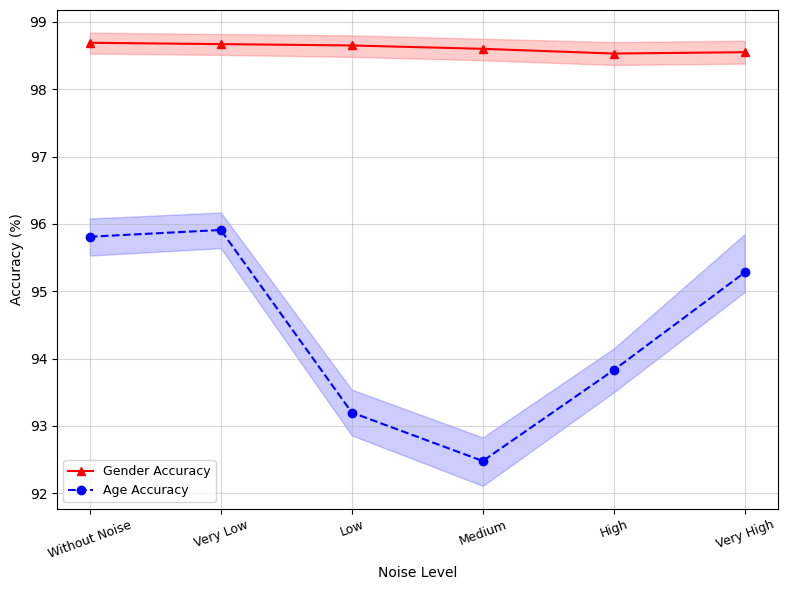

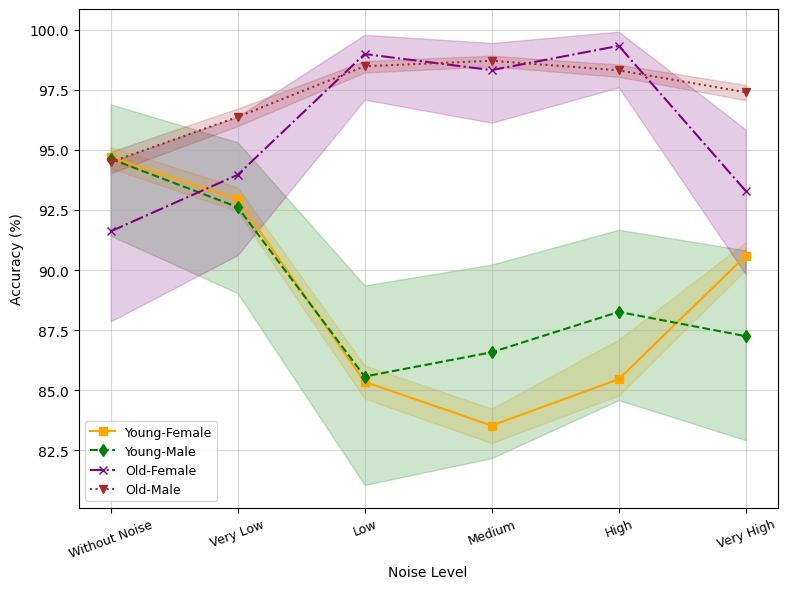

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Noise levels available
noise_levels = ["Without Noise", "Very Low", "Low", "Medium", "High", "Very High"]
x = np.arange(len(noise_levels))

# Test
# ---------------- Overall Accuracies ----------------
gender_acc = [98.69, 98.67, 98.65, 98.60, 98.53, 98.55]
gender_ci  = [(98.53, 98.84), (98.51, 98.82), (98.48, 98.80), (98.43, 98.75), (98.36, 98.70), (98.38, 98.72)]

age_acc = [95.81, 95.91, 93.20, 92.48, 93.83, 95.28]
age_ci  = [(95.53, 96.08), (95.64, 96.17), (92.86, 93.54), (92.11, 92.83), (93.50, 94.15), (94.99, 95.85)]

# ---------------- Pair-wise Accuracies ----------------
young_female = [94.69, 92.95, 85.35, 83.53, 85.46, 90.60]
young_female_ci = [(94.24, 95.12), (92.44, 93.44), (84.65, 86.03), (82.80, 84.24), (84.78, 87.11), (90.02, 91.16)]

young_male = [94.63, 92.62, 85.57, 86.58, 88.26, 87.25]
young_male_ci = [(91.43, 96.90), (89.04, 95.32), (81.06, 89.36), (82.17, 90.23), (84.59, 91.68), (82.92, 90.82)]

old_female = [91.61, 93.96, 98.99, 98.32, 99.33, 93.29]
old_female_ci = [(87.86, 94.50), (90.62, 96.38), (97.09, 99.79), (96.13, 99.45), (97.60, 99.92), (89.82, 95.85)]

old_male = [94.49, 96.37, 98.48, 98.71, 98.31, 97.40]
old_male_ci = [(94.03, 94.92), (95.99, 96.72), (98.22, 98.70), (98.47, 98.92), (98.04, 98.55), (97.07, 97.70)]

# import pandas as pd

# df = pd.read_csv("metrics.csv")

# def load_metric(df, metric_name):
#     subset = df[df["metric"] == metric_name]
#     acc = subset["acc"].tolist()
#     ci = list(zip(subset["ci_low"], subset["ci_high"]))
#     return acc, ci

# gender_acc, gender_ci = load_metric(df, "gender")
# young_male_acc, young_male_ci = load_metric(df, "young_male")

# print(gender_acc, gender_ci)

# --- Styles ---
styles_overall = {
    "Gender": {"color": "red", "marker": "^", "linestyle": "-", "linewidth": 1.5, "zorder": 10},
    "Age": {"color": "blue", "marker": "o", "linestyle": "--", "linewidth": 1.5},
}

styles_pairwise = {
    "Young-Female": {"color": "orange", "marker": "s", "linestyle": "-", "linewidth": 1.5},
    "Young-Male": {"color": "green", "marker": "d", "linestyle": "--", "linewidth": 1.5},
    "Old-Female": {"color": "purple", "marker": "x", "linestyle": "-.", "linewidth": 1.5},
    "Old-Male": {"color": "brown", "marker": "v", "linestyle": ":", "linewidth": 1.5},
}

# --- Overall accuracy plot ---
plt.figure(figsize=(8, 6))

plt.plot(x, gender_acc, label="Gender Accuracy", **styles_overall["Gender"])
plt.fill_between(x, [ci[0] for ci in gender_ci], [ci[1] for ci in gender_ci],
                 color=styles_overall["Gender"]["color"], alpha=0.2)

plt.plot(x, age_acc, label="Age Accuracy", **styles_overall["Age"])
plt.fill_between(x, [ci[0] for ci in age_ci], [ci[1] for ci in age_ci],
                 color=styles_overall["Age"]["color"], alpha=0.2)

plt.xticks(x, noise_levels, rotation=20, fontsize=9)
plt.xlabel("Noise Level", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)
# plt.title("Overall Accuracy vs Noise Level", fontsize=12)
plt.legend(fontsize=9, loc="lower left", frameon=True)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("overall_accuracy_vs_noise_CI_updated.png", bbox_inches='tight', dpi=300)
plt.show()

# --- Pair-wise accuracy plot ---
plt.figure(figsize=(8, 6))

for label, acc, ci, style in [
    ("Young-Female", young_female, young_female_ci, styles_pairwise["Young-Female"]),
    ("Young-Male", young_male, young_male_ci, styles_pairwise["Young-Male"]),
    ("Old-Female", old_female, old_female_ci, styles_pairwise["Old-Female"]),
    ("Old-Male", old_male, old_male_ci, styles_pairwise["Old-Male"]),
]:
    plt.plot(x, acc, label=label, **style)
    plt.fill_between(x, [c[0] for c in ci], [c[1] for c in ci],
                     color=style["color"], alpha=0.2)

plt.xticks(x, noise_levels, rotation=20, fontsize=9)
plt.xlabel("Noise Level", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)
# plt.title("Pair-Wise Accuracy vs Noise Level", fontsize=12)
plt.legend(fontsize=9, loc="lower left", frameon=True)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("pairwise_accuracy_vs_noise_CI_updated.png", bbox_inches='tight', dpi=300)
plt.show()


### DDPM BMNIST 

In [ ]:
import os
import json
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import binomtest
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import random
from collections import defaultdict
from shared_evaluation_code.biased_mnist_utils import get_color_idx_from_batch
import re

# ---------- Utility ----------
def get_rho_confidence_interval_from_counts(nb_aligned, nb_total, confidence_level=0.95):
    if nb_total == 0:
        return 0.0, (0.0, 0.0)
    est_rho_model = nb_aligned / nb_total
    res = binomtest(k=nb_aligned, n=nb_total)
    conf_int = res.proportion_ci(confidence_level=confidence_level, method='exact')
    return est_rho_model, (conf_int.low, conf_int.high)

# ---------- Load Oracle and BMNIST color utility ----------
oracle = LlavaOracle()
# import biased_mnist_utils  # Assumes you have this module

# ---------- Settings ----------
timesteps = ["T_500", "T_600", "T_700", "T_800", "T_900", "T_1000"]
base_path = "/mnt/fast_disk/agjergji/Datasets/generated_images_ddpm_bmnist"
batch_size = 6
max_images = 2000
results = {}

# ---------- Main Loop ----------
for timestep in timesteps:
    print(f"\n=== Processing {timestep} ===")
    folder_path = os.path.join(base_path, timestep)

    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} not found. Skipping...")
        continue

    # Load up to max_images
    all_files = sorted([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(".png")
    ])[:max_images]

    if len(all_files) == 0:
        print("No images found.")
        continue

    image_paths = [os.path.join(folder_path, f) for f in all_files]
    aligned = 0
    total = 0

    transform = transforms.ToTensor()  # Needed to convert PIL to torch.Tensor

    for i in tqdm(range(0, len(image_paths), batch_size), desc=f"Evaluating {timestep}"):
        batch_paths = image_paths[i:i + batch_size]

        for img_path in batch_paths:
            img_pil = Image.open(img_path).convert("RGB")
            img_tensor = transform(img_pil).unsqueeze(0).to(device)  # [1, C, H, W]

            # --- Predict digit ---
            digit_pred = oracle.predict_digit(img_tensor)[0]  # 1 = digit 0, 0 = otherwise

            # --- Get color idx (0=blue, 1=red) ---
            color_idx = get_color_idx_from_batch(img_tensor, allowed_colors=[0, 1])
            color_idx = color_idx.cpu().numpy()[0]

            # print(f"color_idx={color_idx}")
            # print(f"digit_pred={digit_pred}")

            # --- Bias-alignment rule ---
            # Bias-aligned if digit_pred == 0 and color_idx == 1 (1, green) or (digit_pred == 1 and color_idx == 0) (0, red)
            if (digit_pred == 0 and color_idx == 1) or (digit_pred == 1 and color_idx == 0):
                aligned += 1
                # Plot every 20th bias-aligned image
                # if color_idx == 1:  # Only plot green bias-aligned images
                # plt.imshow(img_pil)
                # plt.title(f"Bias-aligned: digit_pred={digit_pred}, color_idx={color_idx}")
                # plt.axis('off')
                # plt.show()

            total += 1

    rho, (low, high) = get_rho_confidence_interval_from_counts(aligned, total)

    results[timestep] = {
        "rho": rho,
        "conf_low": low,
        "conf_high": high,
        "total": total,
        "aligned": aligned
    }

    print(f"\n{timestep} - ρ: {rho:.4f}, CI: [{low:.4f}, {high:.4f}], Aligned: {aligned}, Total: {total}")

# # ---------- Save results ----------
with open("rho_results_bmnist.json", "w") as f:
    json.dump(results, f, indent=2)

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Load results if already computed
if os.path.exists("rho_results_bmnist.json"):
    with open("rho_results_bmnist.json", "r") as f:
        results = json.load(f)

# Prepare data
timesteps_sorted = sorted(results.keys(), key=lambda x: int(x.split("_")[1]))
x = np.array([int(t.split("_")[1]) for t in timesteps_sorted])
y = np.array([results[t]['rho'] for t in timesteps_sorted])
y_low = np.array([results[t]['conf_low'] for t in timesteps_sorted])
y_high = np.array([results[t]['conf_high'] for t in timesteps_sorted])

# Plot with shaded confidence interval
plt.figure(figsize=(8, 6))

plt.fill_between(x, y_low, y_high, color='blue', alpha=0.2)
plt.plot(x, y, 'o-', color='blue', label=r"$\rho_\text{model}$")

plt.axhline(y=0.90, color='red', linestyle='--', label=r"$\rho_\text{dataset}=0.90$")

plt.xlabel(r"$\text{Timestep}$", fontsize=10)
plt.ylabel(r"$\rho_\text{model}$", fontsize=10)
plt.xticks(x, labels=[f"T={v}" for v in x], rotation=45)
plt.ylim(0.2, 1.0)

plt.grid(True, alpha=0.6)
plt.legend(fontsize=8, loc='lower right', frameon=True)
# plt.savefig("rho_by_timestep_bmnist.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()